# Import Libraries and Constants

In [894]:
%matplotlib inline
import torch as th
#import torch.nn.functional as F
import torch.nn as nn 
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
#from sklearn.model_selection import train_test_split,  RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_tweedie_score, make_scorer, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from skorch import NeuralNetRegressor, NeuralNet, callbacks
import utils
import architecture
import run_config

In [895]:
NUM_ROUNDS = run_config.server_config["num_rounds"]

In [896]:
FL_PATH = '../ag_-1/fl_model.pt'

In [897]:
FL_NUM_UNITS_1 = 40

In [898]:
FL_NUM_UNITS_2 = 60

In [899]:
NUM_FEATURES = run_config.model_architecture["num_features"]

# Load Models

Get number of units from neural network

In [900]:
all_results_df = pd.read_csv('../results/all_results.csv')
all_results_df 

params_key  mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     0.01_5_10     606.472644           0.0         0.617478             0.0   
1    0.01_10_10     607.438273           0.0         0.634315             0.0   
2    0.01_15_10     616.284569           0.0         0.598443             0.0   
3    0.001_5_15     609.458550           0.0         0.575462             0.0   
4    0.01_10_15     611.409616           0.0         0.588439             0.0   
..          ...            ...           ...              ...             ...   
160   0.01_5_10      60.908979           0.0         0.114690             0.0   
161  0.01_10_10      61.204493           0.0         0.054853             0.0   
162  0.01_10_15      61.703243           0.0         0.060837             0.0   
163   0.01_5_15      61.239322           0.0         0.057846             0.0   
164  0.01_15_10      62.036757           0.0         0.052856             0.0   

     param_optimizer__lr  param_module__num_units_2  \
0                  0.010                          5   
1                  0.010                         10   
2                  0.010                         15   
3                  0.001                          5   
4                  0.010                         10   
..                   ...                        ...   
160                0.010                          5   
161                0.010                         10   
162                0.010                         10   
163                0.010                          5   
164                0.010                         15   

     param_module__num_units_1  \
0                           10   
1                           10   
2                           10   
3                           15   
4                           15   
..                         ...   
160                         10   
161                         10   
162                         15   
163                         15   
164                         10   

                                                params  split0_test_score  \
0    {'optimizer__lr': 0.01, 'module__num_units_2':...           0.054613   
1    {'optimizer__lr': 0.01, 'module__num_units_2':...           0.052728   
2    {'optimizer__lr': 0.01, 'module__num_units_2':...           0.051248   
3    {'optimizer__lr': 0.001, 'module__num_units_2'...           0.048734   
4    {'optimizer__lr': 0.01, 'module__num_units_2':...           0.048304   
..                                                 ...                ...   
160  {'optimizer__lr': 0.01, 'module__num_units_2':...           0.023304   
161  {'optimizer__lr': 0.01, 'module__num_units_2':...           0.014324   
162  {'optimizer__lr': 0.01, 'module__num_units_2':...          -0.001400   
163  {'optimizer__lr': 0.01, 'module__num_units_2':...          -0.008167   
164  {'optimizer__lr': 0.01, 'module__num_units_2':...          -0.009781   

     ...  test_mean_poisson_deviance  test_weighted_mean_poisson_deviance  \
0    ...                    0.296439                             0.344349   
1    ...                    0.296439                             0.344349   
2    ...                    0.296439                             0.344349   
3    ...                    0.296439                             0.344349   
4    ...                    0.296439                             0.344349   
..   ...                         ...                                  ...   
160  ...                    0.305200                             0.351865   
161  ...                    0.305200                             0.351865   
162  ...                    0.305200                             0.351865   
163  ...                    0.305200                             0.351865   
164  ...                    0.305200                             0.351865   

     test_pde  test_weighted_pde  test_r^2  test_gini  test_min_pred  \
0    0.071895           0.052663  0.0277

Filter to just best hyperparameters

In [901]:
top_results_df = all_results_df.loc[all_results_df['rank_test_score']==1]
top_results_df

params_key  mean_fit_time  std_fit_time  mean_score_time  \
0      0.01_5_10     606.472644           0.0         0.617478   
15   0.001_10_10      59.410127           0.0         0.055851   
30    0.001_5_15      60.795509           0.0         0.055851   
45   0.001_10_15      64.707525           0.0         0.061834   
60     0.01_10_5      61.057590           0.0         0.057845   
75   0.001_10_10      61.428329           0.0         0.077828   
90    0.001_10_5      60.879845           0.0         0.067818   
105  0.001_15_15      61.367987           0.0         0.062832   
120  0.001_15_15      61.470992           0.0         0.060891   
135  0.001_15_10      61.792516           0.0         0.064797   
150   0.001_15_5      60.953165           0.0         0.064825   

     std_score_time  param_optimizer__lr  param_module__num_units_2  \
0               0.0                0.010                          5   
15              0.0                0.001                         10   
30              0.0                0.001                          5   
45              0.0                0.001                         10   
60              0.0                0.010                         10   
75              0.0                0.001                         10   
90              0.0                0.001                         10   
105             0.0                0.001                         15   
120             0.0                0.001                         15   
135             0.0                0.001                         15   
150             0.0                0.001                         15   

     param_module__num_units_1  \
0                           10   
15                          10   
30                          15   
45                          15   
60                           5   
75                          10   
90                           5   
105                         15   
120                         15   
135                         10   
150                          5   

                                                params  split0_test_score  \
0    {'optimizer__lr': 0.01, 'module__num_units_2':...           0.054613   
15   {'optimizer__lr': 0.001, 'module__num_units_2'...           0.035391   
30   {'optimizer__lr': 0.001, 'module__num_units_2'...           0.052351   
45   {'optimizer__lr': 0.001, 'module__num_units_2'...           0.038782   
60   {'optimizer__lr': 0.01, 'module__num_units_2':...           0.045890   
75   {'optimizer__lr': 0.001, 'module__num_units_2'...           0.034255   
90   {'optimizer__lr': 0.001, 'module__num_units_2'...           0.028442   
105  {'optimizer__lr': 0.001, 'module__num_units_2'...           0.030516   
120  {'optimizer__lr': 0.001, 'module__num_units_2'...           0.026740   
135  {'optimizer__lr': 0.001, 'module__num_units_2'...           0.035597   
150  {'optimizer__lr': 0.001, 'module__num_units_2'...           0.037352   

     ...  test_mean_poisson_deviance  test_weighted_mean_poisson_deviance  \
0    ...                    0.296439                             0.344349   
15   ...                    0.303765                             0.351569   
30   ...                    0.308816                             0.355254   
45   ...                    0.304243                             0.351874   
60   ...                    0.302915                             0.351206   
75   ...                    0.303942                             0.351433   
90   ...                    0.305324                             0.352078   
105  ...                    0.304218                             0.352139   
120  ...                    0.304825                             0.351590   
135  ...                    0.303570                             0.351318   
150  ...                    0.305200                             0.351865   

     test_pde  test_weighted_pde  test_r^2  test_gini  test_min_pred  \
0    0.071895           0.052

In [902]:
top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']]

agent  param_module__num_units_1  param_module__num_units_2
0       -1                         10                          5
15       0                         10                         10
30       1                         15                          5
45       2                         15                         10
60       3                          5                         10
75       4                         10                         10
90       5                          5                         10
105      6                         15                         15
120      7                         15                         15
135      8                         10                         15
150      9                          5                         15

Create dictionary to lookup hyperparameters

In [903]:
top_results_dict = top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']].set_index('agent').to_dict('index')
top_results_dict

{-1: {'param_module__num_units_1': 10, 'param_module__num_units_2': 5},
 0: {'param_module__num_units_1': 10, 'param_module__num_units_2': 10},
 1: {'param_module__num_units_1': 15, 'param_module__num_units_2': 5},
 2: {'param_module__num_units_1': 15, 'param_module__num_units_2': 10},
 3: {'param_module__num_units_1': 5, 'param_module__num_units_2': 10},
 4: {'param_module__num_units_1': 10, 'param_module__num_units_2': 10},
 5: {'param_module__num_units_1': 5, 'param_module__num_units_2': 10},
 6: {'param_module__num_units_1': 15, 'param_module__num_units_2': 15},
 7: {'param_module__num_units_1': 15, 'param_module__num_units_2': 15},
 8: {'param_module__num_units_1': 10, 'param_module__num_units_2': 15},
 9: {'param_module__num_units_1': 5, 'param_module__num_units_2': 15}}

Use dictionary to access results, for example to lookup `agent=0`:

In [904]:
top_results_dict[-1]

{'param_module__num_units_1': 10, 'param_module__num_units_2': 5}

In [905]:
list(top_results_dict[-1].items())[0][1]

10

In [906]:
list(top_results_dict[-1].items())[1][1]

5

## Create load model function

In [907]:
def load_model(agent=-1, num_features=NUM_FEATURES):

    num_units_1 = list(top_results_dict[agent].items())[0][1]
    num_units_2 = list(top_results_dict[agent].items())[1][1]
    #num_units_3 = list(top_results_dict[agent].items())[2][1]

    loaded_agent_model = NeuralNetRegressor(architecture.MultipleRegression(num_features, num_units_1, num_units_2).double())
    loaded_agent_model.initialize()  # This is important!
    loaded_agent_model.load_params(f_params=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_model.pkl', 
                                       f_optimizer=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_opt.pkl', 
                                       f_history=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_history.json')
    
    return loaded_agent_model

## Loop through

In [908]:
NUM_AGENTS = 10

In [909]:
agent_model_dictionary = {}
for agents in range(NUM_AGENTS):
    agent_model_dictionary["loaded_agent_{0}_model".format(agents)] = eval('load_model(agent='+str(agents)+')')

## Load Federated Model

In [910]:
fl_model = architecture.MultipleRegression(num_features=NUM_FEATURES, num_units_1=FL_NUM_UNITS_1, num_units_2=FL_NUM_UNITS_2)
fl_model

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=60, bias=True)
  (layer_out): Linear(in_features=60, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act): Tanh()
)

In [911]:
fl_model.load_state_dict(th.load(FL_PATH))
fl_model.eval()

MultipleRegression(
  (layer_1): Linear(in_features=39, out_features=40, bias=True)
  (layer_2): Linear(in_features=40, out_features=60, bias=True)
  (layer_out): Linear(in_features=60, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (act): Tanh()
)

Again can lookup each agent's model

In [912]:
agent_model_dictionary['loaded_agent_0_model']

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MultipleRegression(
    (layer_1): Linear(in_features=39, out_features=10, bias=True)
    (layer_2): Linear(in_features=10, out_features=10, bias=True)
    (layer_out): Linear(in_features=10, out_features=1, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (act): Tanh()
  ),
)

## Load global model

In [913]:
loaded_agent_global_model = load_model(agent=-1)

# Load Test Data and Functions

In [914]:
def frequency_conversion(FACTOR, df, freq_dictionary):
      for key in freq_dictionary:
            df[freq_dictionary[key]]=df[key]/df['Exposure']

      df.insert(1,FACTOR+'_binned_midpoint',[round((a.left + a.right)/2,0) for a in df[FACTOR+'_binned']])

In [915]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [916]:
def create_test_data(): 
    (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
    
    MY_DATA_PATH = '../data'
    
    X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
    y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
    X_column_names = X_test_sc.columns.tolist()

    test_complete_data=np.column_stack((X_test_sc, y_te))

    X_column_names.append('ClaimNb')

    #Convert dataset of test data, actuals, and prediction back into dataframe

    df_test=pd.DataFrame(data=test_complete_data,    # values
                    columns=X_column_names)  # 1st row as the column names
    
    # Un one-hot encode Region and VehBrand
    df_test = undummify(df_test)
    df_test['VehBrand_number'] = df_test['VehBrand'].str[1:].astype(int)
    df_test['Region_number'] = df_test['Region'].str[1:].astype(int)


    df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
    
    #Bin factors
    factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']
    
    # If fewer levels than MAX_BINSIZE no effective binning happens via the min() function, not used currently
    MAX_BINSIZE = 20

    # Automatic binning not used, could use qcut as well 
    for i in factor_list:
        df_test[i+'_binned'] = pd.cut(df_test[i], bins=min(len(df_test[i].unique()), MAX_BINSIZE), duplicates='drop')
        #df_test[i+'_binned'] = pd.cut(df_test[i], bins=np.linspace(0, max(df_test[i]), min(21, len(df_test[i].unique()))), duplicates='drop')
    
    # Custom binning used instead to define more sensible bins
    df_test['Area'+'_binned'] = pd.cut(df_test['Area'], bins=np.linspace(0, 7, 8), duplicates='drop')
    df_test['VehPower'+'_binned'] = pd.cut(df_test['VehPower'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['VehAge'+'_binned'] = pd.cut(df_test['VehAge'], bins=np.linspace(0, 20, 21), duplicates='drop')
    df_test['DrivAge'+'_binned'] = pd.cut(df_test['DrivAge'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['BonusMalus'+'_binned'] = pd.qcut(df_test['BonusMalus'], q=15, duplicates='drop') # note usin qcut here
    df_test['Density'+'_binned'] = pd.cut(df_test['Density'], bins=np.linspace(0, 11, 12), duplicates='drop')
    df_test['VehBrand_number'+'_binned'] = pd.cut(df_test['VehBrand_number'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['Region_number'+'_binned'] = pd.cut(df_test['Region_number'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['VehGas'+'_binned'] = pd.cut(df_test['VehGas'], bins=np.linspace(0, 2, 3), duplicates='drop')
    
    return X_test, y_test, df_test

In [917]:
X_test, y_test, df_test = create_test_data()

In [918]:
def create_df_test_pred(df_test, X_test, global_model, NUM_AGENTS):
    
    # Global Model Predictions
    y_pred = global_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())

    # FL Model Predictions
    y_fl_pred = fl_model.predict(th.tensor(X_test).float())
    df_test['ClaimNb_fl_pred']=pd.Series(y_fl_pred.flatten().detach().numpy())

    # Local Model Predictions

    agent_prediction_dictionary = {}

    for agents in range(NUM_AGENTS):
        agent_prediction_dictionary["y_agent_{0}_pred".format(agents)] = agent_model_dictionary['loaded_agent_'+str(agents)+'_model'].predict(X_test.astype(np.float64))
        df_test['ClaimNb_agent_'+str(agents)+'_pred']=pd.Series(agent_prediction_dictionary['y_agent_'+str(agents)+'_pred'].flatten())

    return df_test

In [919]:
df_test_pred = create_df_test_pred(df_test, X_test, loaded_agent_global_model, NUM_AGENTS)
#df_test_pred = create_df_test_pred(df_test, X_test, loaded_agent_global_model, 1)

In [920]:
df_test_pred['ClaimNb_pred_binned'] = pd.qcut(df_test_pred['ClaimNb_pred'], 25, duplicates='drop')
#df_test_pred['ClaimNb_pred_binned'] = pd.cut(df_test_pred['ClaimNb_pred'], bins=np.linspace(0, 0.65, 20), duplicates='drop')
#df_test_pred['ClaimNb_pred_binned'] = pd.cut(df_test_pred['ClaimNb_pred'], bins=[0,
                                                                                 #0.015,
                                                                                 #0.02,
                                                                                 #0.0225,
                                                                                 #0.025,
                                                                                 #0.0275,
                                                                                 #0.03,
                                                                                 #0.0325,
                                                                                 #0.035,
                                                                                 #0.0375,
                                                                                 #0.04,
                                                                                 #0.0425,
                                                                                 #0.045,
                                                                                 #0.0475,
                                                                                 #0.05,
                                                                                 #0.0535,
                                                                                 #0.0585,
                                                                                 #0.065,
                                                                                 #0.0725,
                                                                                 #0.085,
                                                                                 #0.155,
                                                                                 #10,
                                                                                #], duplicates='drop')
df_test_pred

Exposure  Area  VehPower  VehAge  DrivAge  BonusMalus  VehGas  \
0       1.000000   1.0       4.0    11.0     45.0        50.0     1.0   
1       0.700000   3.0       7.0     3.0     26.0        68.0     1.0   
2       0.460000   4.0       9.0    15.0     21.0        95.0     1.0   
3       0.450000   5.0       4.0     0.0     69.0        50.0     1.0   
4       0.490000   6.0       9.0     1.0     57.0        50.0     1.0   
...          ...   ...       ...     ...      ...         ...     ...   
135598  0.070000   3.0       9.0     0.0     53.0        50.0     1.0   
135599  0.110000   3.0       9.0    16.0     37.0        50.0     1.0   
135600  0.008219   4.0       7.0     0.0     56.0        50.0     1.0   
135601  0.280000   5.0       5.0    17.0     50.0        90.0     1.0   
135602  0.210000   2.0      10.0     5.0     68.0        50.0     2.0   

          Density VehBrand Region  ...  ClaimNb_agent_1_pred  \
0        2.197225       B3    R24  ...              0.042075   
1        5.774552       B6    R31  ...              0.051672   
2        6.960348       B3    R24  ...              0.045571   
3        8.325548      B12    R52  ...              0.061431   
4       10.060320       B2    R21  ...              0.054367   
...           ...      ...    ...  ...                   ...   
135598   5.953243      B12    R82  ...              0.045180   
135599   6.003887      B14    R24  ...              0.034377   
135600   6.628041      B12    R26  ...              0.051416   
135601   9.138522       B5    R82  ...              0.049125   
135602   4.430817      B12    R52  ...              0.038523   

        ClaimNb_agent_2_pred  ClaimNb_agent_3_pred ClaimNb_agent_4_pred  \
0                   0.051440              0.039959             0.055563   
1                   0.039081              0.055658             0.055788   
2                   0.057087              0.086093             0.102909   
3                   0.122126              0.169678             0.074739   
4                   0.046061              0.076142             0.049575   
...                      ...                   ...                  ...   
135598              0.081093              0.193779             0.133633   
135599              0.012836              0.006805             0.015661   
135600              0.052124              0.132198             0.126394   
135601              0.074324              0.094622             0.072902   
135602              0.029452              0.029781             0.022526   

       ClaimNb_agent_5_pred ClaimNb_agent_6_pred ClaimNb_agent_7_pred  \
0                  0.054955             0.038182             0.042728   
1                  0.043917             0.063399             0.061582   
2                  0.071018             0.078889             0.073573   
3                  0.168407             0.167799             0.081329   
4                  0.057968             0.053488             0.059809   
...                     ...                  ...                  ...   
135598             0.099936             0.081147             0.114385   
135599             0.015640             0.014955             0.023546   
135600             0.112618             0.065720             0.077842   
135601             0.056019             0.072904             0.044347   
135602             0.030453             0.018290             0.023114   

       ClaimNb_agent_8_pred ClaimNb_agent_9_pred ClaimNb_pred_binned  
0                  0.044594             0.038219     (0.0312, 0.034]  
1                  0.056204             0.045108    (0.0578, 0.0589]  
2                  0.074718             0.060034     (0.0763, 0.105]  
3                  0.152713             0.118577       (0.17, 0.542]  
4                  0.049519             0.061873    (0.0564, 0.0578]  
...                     ...                  ...                 ...  
135598             0.089319             0.070066       (0.17, 0.542]  
135599          

In [921]:
sum_list = ['Exposure',  'ClaimNb', 'ClaimNb_pred', 'ClaimNb_fl_pred', 
            'ClaimNb_agent_0_pred', 
            # 'ClaimNb_agent_7_pred'
            ]
#sum_dictionary = {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_fl_pred':'Freq pred FL model', 'ClaimNb_fl_pred':'Freq pred FL model'}
df_sum=df_test_pred.groupby(['ClaimNb_pred_binned'])[sum_list].sum().reset_index()
#df_sum['ClaimNb_freq']=df_sum['ClaimNb']/df_sum['Exposure']
#df_sum['ClaimNb_pred_freq']=df_sum['ClaimNb_pred']/df_sum['Exposure']
#df_sum['ClaimNb_fl_pred_freq']=df_sum['ClaimNb_fl_pred']/df_sum['Exposure']
#df_sum['ClaimNb_agent_0_pred_freq']=df_sum['ClaimNb_agent_0_pred']/df_sum['Exposure']
df_sum['ClaimNb_rebased'] = df_sum['ClaimNb']/df_sum['ClaimNb']
df_sum['ClaimNb_pred_rebased'] = df_sum['ClaimNb_pred']/df_sum['ClaimNb']
df_sum['ClaimNb_fl_pred_rebased'] = df_sum['ClaimNb_fl_pred']/df_sum['ClaimNb']
df_sum['ClaimNb_agent_0_pred_rebased'] = df_sum['ClaimNb_agent_0_pred']/df_sum['ClaimNb']
df_sum

ClaimNb_pred_binned     Exposure  ClaimNb  ClaimNb_pred  ClaimNb_fl_pred  \
0     (0.0093, 0.0119]   389.944498     58.0     59.825870        76.406555   
1      (0.0119, 0.014]   469.406685     89.0     69.783244        86.047104   
2      (0.014, 0.0174]   533.365527     97.0     84.322234        97.406403   
3     (0.0174, 0.0219]   661.441000    109.0    106.250315       109.705605   
4     (0.0219, 0.0265]   906.830485    109.0    131.680257       122.513039   
5      (0.0265, 0.029]  1362.515476    128.0    151.179966       134.342743   
6      (0.029, 0.0297]  2743.332969    158.0    158.889390       151.335556   
7     (0.0297, 0.0312]  2698.913382    170.0    164.715079       167.775192   
8      (0.0312, 0.034]  2459.778017    202.0    176.309075       180.591858   
9      (0.034, 0.0381]  2602.444510    183.0    194.979186       194.011719   
10    (0.0381, 0.0428]  2685.801395    207.0    219.399548       208.699081   
11    (0.0428, 0.0475]  2773.689377    268.0    245.131768       220.193207   
12    (0.0475, 0.0513]  2826.874971    251.0    268.477617       231.468307   
13    (0.0513, 0.0536]  3066.328349    256.0    284.973236       251.434082   
14    (0.0536, 0.0551]  3277.980959    313.0    294.989061       268.315887   
15    (0.0551, 0.0564]  3632.783691    280.0    302.427100       283.301605   
16    (0.0564, 0.0578]  4141.389178    286.0    309.912584       294.482117   
17    (0.0578, 0.0589]  4646.635472    306.0    316.641473       314.469543   
18    (0.0589, 0.0604]  4721.585479    313.0    323.366144       344.718719   
19    (0.0604, 0.0628]  4687.895464    348.0    333.502261       373.994629   
20    (0.0628, 0.0673]  4546.730944    355.0    351.629418       402.429443   
21    (0.0673, 0.0763]  4409.330115    425.0    386.668495       444.591370   
22     (0.0763, 0.105]  4188.539178    520.0    471.677539       489.552673   
23       (0.105, 0.17]  3534.815718    668.0    744.106010       586.457153   
24       (0.17, 0.542]  3601.343813   1064.0   1135.724531       996.913391   

    ClaimNb_agent_0_pred  ClaimNb_rebased  ClaimNb_pred_rebased  \
0             145.168583              1.0              1.031481   
1             144.389298              1.0              0.784081   
2             146.868471              1.0              0.869301   
3             157.667117              1.0              0.974774   
4             172.286348              1.0              1.208076   
5             177.055995              1.0              1.181093   
6             197.368337              1.0              1.005629   
7             217.380501              1.0              0.968912   
8             221.110596              1.0              0.872817   
9             238.745979              1.0              1.065460   
10            242.655107              1.0              1.059901   
11            252.110980              1.0              0.914671   
12            255.285462              1.0              1.069632   
13            263.456053              1.0              1.113177   
14            275.607775              1.0              0.942457   
15            293.840839              1.0              1.080097   
16            314.639331              1.0              1.083610   
17            350.239309              1.0              1.034776   
18            382.208770              1.0              1.033119   
19            399.032343              1.0              0.958340   
20            416.185697              1.0              0.990505   
21            448.145910              1.0              0.909808   
22            495.956596              1.0              0.907072   
23            595.010300              1.0              1.113931   
24            886.527341              1.0              1.067410   

    ClaimNb_fl_pred_rebased  ClaimNb_agent_0_pred_rebased  
0                  1.317354                      2.502907  
1                  0.966821                      1.622352  
2                  1.0041

FixedFormatter should only be used together with FixedLocator


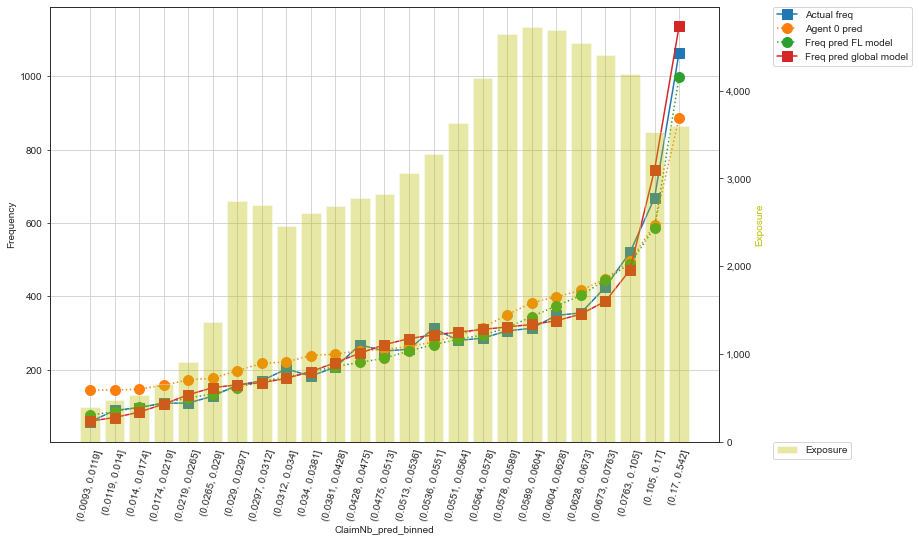

In [922]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(df_sum['ClaimNb'],  
        label='Actual freq',
        marker='s',
        markersize=10,
        )

#for agents in range(NUM_AGENTS):
        #plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
        #label='Freq pred agent '+str(agents)+' model',
        #marker='o',
        #markersize=5,
        #linestyle=(0, (1, 10)),
        #linestyle='dotted',
        #)
plt.plot(df_sum['ClaimNb_agent_0_pred'],  
        label='Agent 0 pred',
        marker='o',
        markersize=10,
        linestyle='dotted',
        )

#plt.plot(df_sum['ClaimNb_agent_7_pred'],  
        #label='Agent 7 pred',
        #marker='o',
        #markersize=10,
        #linestyle='dotted',
        #)

plt.plot(df_sum['ClaimNb_fl_pred'],  
        label='Freq pred FL model',
        marker='o',
        markersize=10,
        linestyle='dotted',
        )

plt.plot(df_sum['ClaimNb_pred'],  
        label='Freq pred global model',
        marker='s',
        markersize=10,
        #linestyle='dotted',
        )

plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

plt.xlabel('ClaimNb_pred_binned')
plt.xticks(rotation = 75)
plt.ylabel('Frequency')
plt.grid()


# Get second axis
ax2 = ax.twinx()

plt.bar(df_sum['ClaimNb_pred_binned'].astype(str), 
        df_sum['Exposure'], 
        label='Exposure', 
        color='y',
        alpha=0.35
        )

plt.ylabel('Exposure', color='y')
plt.xticks(rotation = 90)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

plt.show()

FixedFormatter should only be used together with FixedLocator


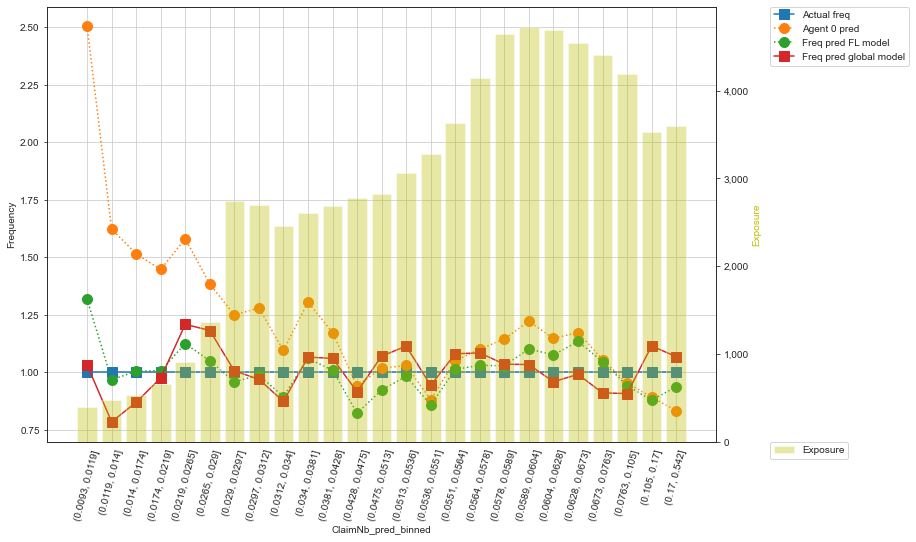

In [924]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(df_sum['ClaimNb_rebased'],  
        label='Actual freq',
        marker='s',
        markersize=10,
        )

#for agents in range(NUM_AGENTS):
        #plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
        #label='Freq pred agent '+str(agents)+' model',
        #marker='o',
        #markersize=5,
        #linestyle=(0, (1, 10)),
        #linestyle='dotted',
        #)
plt.plot(df_sum['ClaimNb_agent_0_pred_rebased'],  
        label='Agent 0 pred',
        marker='o',
        markersize=10,
        linestyle='dotted',
        )

#plt.plot(df_sum['ClaimNb_agent_7_pred'],  
        #label='Agent 7 pred',
        #marker='o',
        #markersize=10,
        #linestyle='dotted',
        #)

plt.plot(df_sum['ClaimNb_fl_pred_rebased'],  
        label='Freq pred FL model',
        marker='o',
        markersize=10,
        linestyle='dotted',
        )

plt.plot(df_sum['ClaimNb_pred_rebased'],  
        label='Freq pred global model',
        marker='s',
        markersize=10,
        #linestyle='dotted',
        )

plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

plt.xlabel('ClaimNb_pred_binned')
plt.xticks(rotation = 75)
plt.ylabel('Frequency')
plt.grid()


# Get second axis
ax2 = ax.twinx()

plt.bar(df_sum['ClaimNb_pred_binned'].astype(str), 
        df_sum['Exposure'], 
        label='Exposure', 
        color='y',
        alpha=0.35
        )

plt.ylabel('Exposure', color='y')
plt.xticks(rotation = 90)

vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

plt.show()

In [925]:
def create_df_sum(df_test_pred, factor, NUM_AGENTS):

    sum_list = ['Exposure',  'ClaimNb', 'ClaimNb_pred', 'ClaimNb_fl_pred']
    sum_dictionary = {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model', 'ClaimNb_fl_pred':'Freq pred FL model'}

    for agents in range(NUM_AGENTS):
        sum_list.append('ClaimNb_agent_'+str(agents)+'_pred')
        sum_dictionary['ClaimNb_agent_'+str(agents)+'_pred']='Freq pred agent '+str(agents)+' model'

    df_sum=df_test_pred.groupby([factor+'_binned'])[sum_list].sum().reset_index()

    frequency_conversion(factor, df_sum, sum_dictionary)

    # Remove rows with 0 exposure
    df_sum = df_sum.loc[df_sum['Exposure']!=0]
    df_sum = df_sum.reset_index(drop=True)

    return df_sum

In [926]:
def one_way_graph_comparison(factor, NUM_AGENTS):

        df_sum = create_df_sum(df_test_pred, factor, NUM_AGENTS)
        
        fig, ax = plt.subplots(figsize=(12, 8))

        plt.plot(df_sum['Actual freq'],  
                label='Actual freq',
                marker='s',
                markersize=10,
                )
        
        for agents in range(NUM_AGENTS):
                plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
                label='Freq pred agent '+str(agents)+' model',
                marker='o',
                markersize=5,
                linestyle=(0, (1, 10)),
                #linestyle='dotted',
                )


        plt.plot(df_sum['Freq pred FL model'],  
                label='Freq pred FL model',
                marker='o',
                markersize=10,
                #linestyle='dotted',
                )
        
        plt.plot(df_sum['Freq pred global model'],  
                label='Freq pred global model',
                marker='s',
                markersize=10,
                #linestyle='dotted',
                )

        plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

        plt.xlabel(factor+'_binned')
        plt.xticks(rotation = 75)
        plt.ylabel('Frequency')
        plt.grid()


        # Get second axis
        ax2 = ax.twinx()

        plt.bar(df_sum[factor+'_binned'].astype(str), 
                df_sum['Exposure'], 
                label='Exposure', 
                color='y',
                alpha=0.35
                )

        plt.ylabel('Exposure', color='y')
        plt.xticks(rotation = 90)

        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

        plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

        plt.show()

# One Way AvE Graphs

FixedFormatter should only be used together with FixedLocator


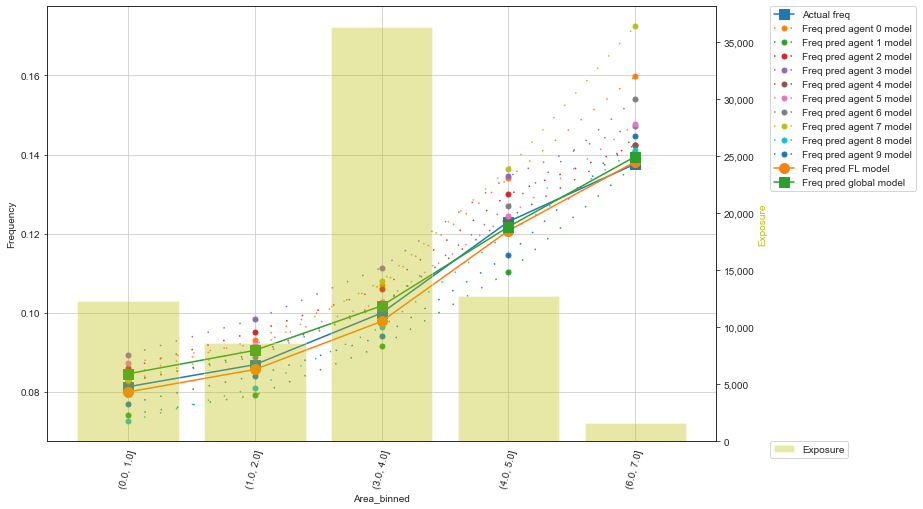

FixedFormatter should only be used together with FixedLocator


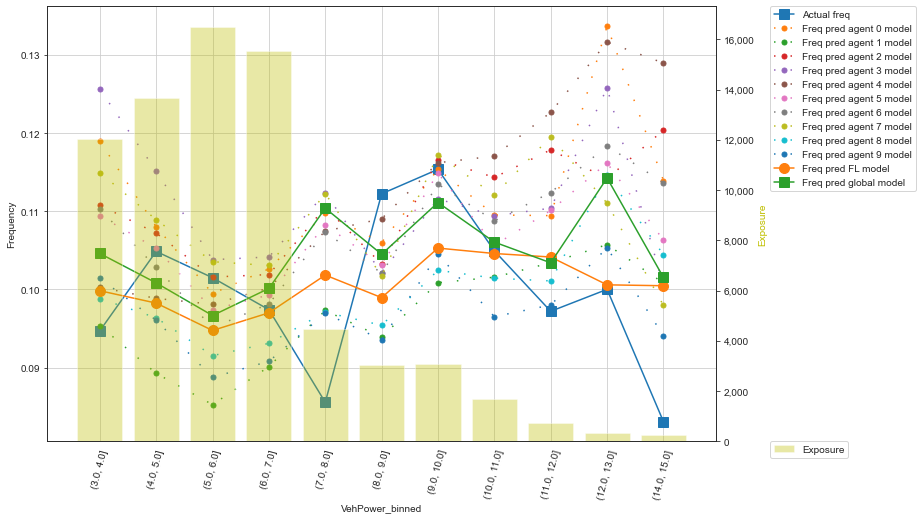

FixedFormatter should only be used together with FixedLocator


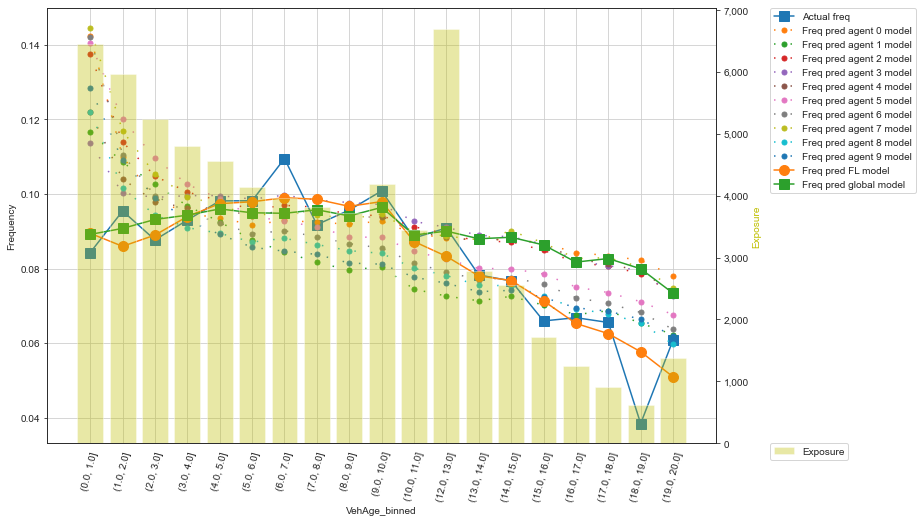

FixedFormatter should only be used together with FixedLocator


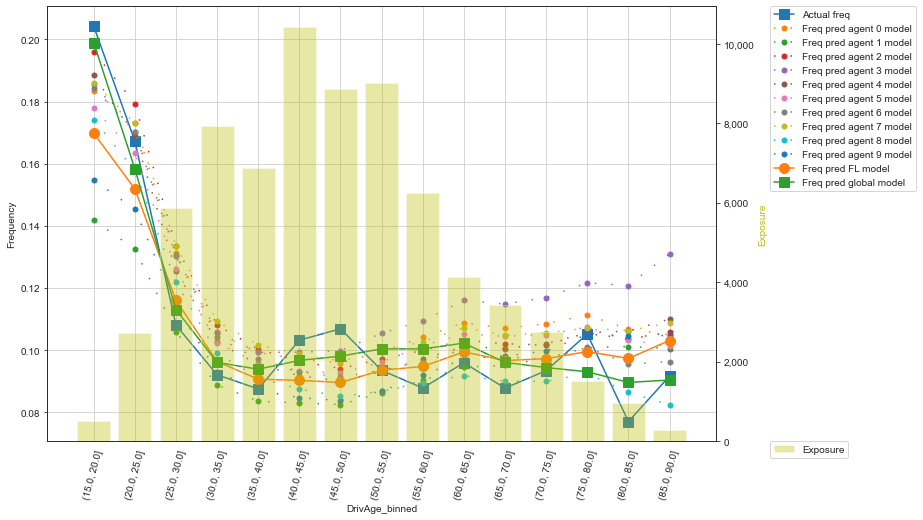

FixedFormatter should only be used together with FixedLocator


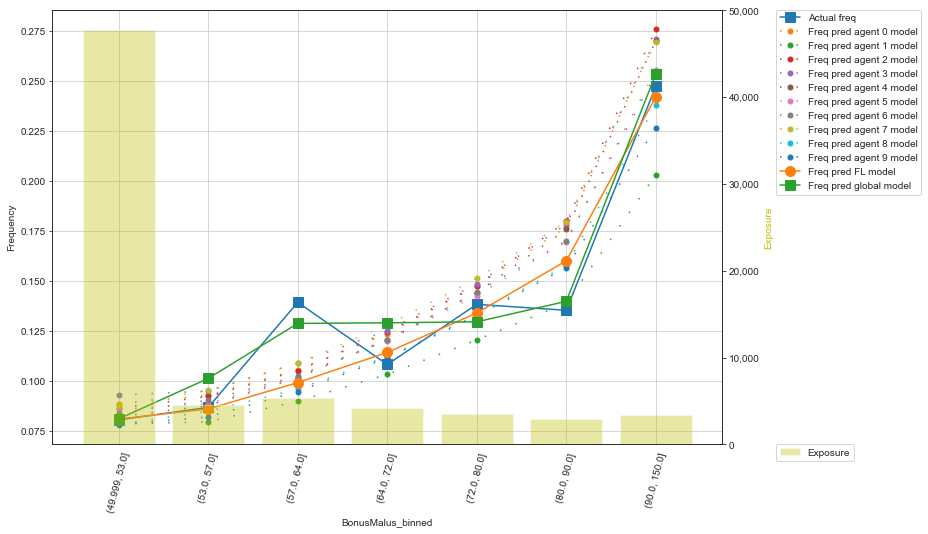

FixedFormatter should only be used together with FixedLocator


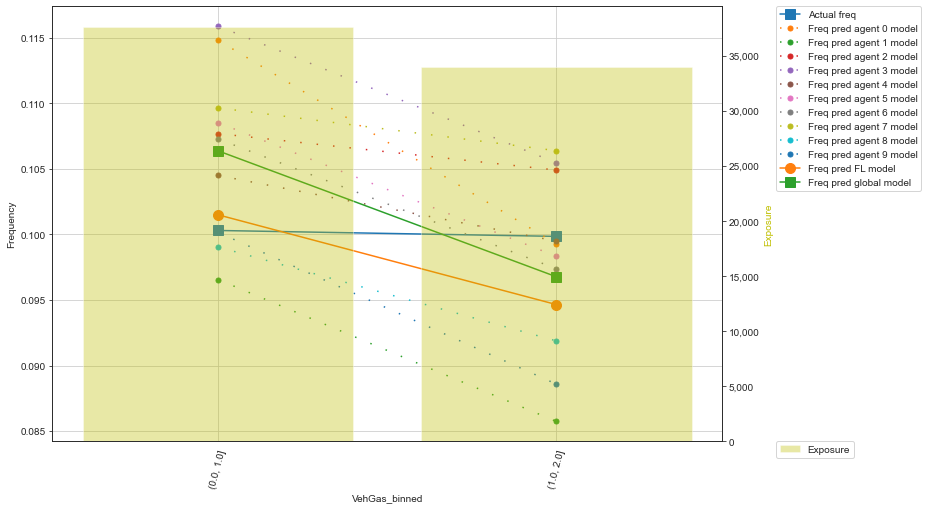

FixedFormatter should only be used together with FixedLocator


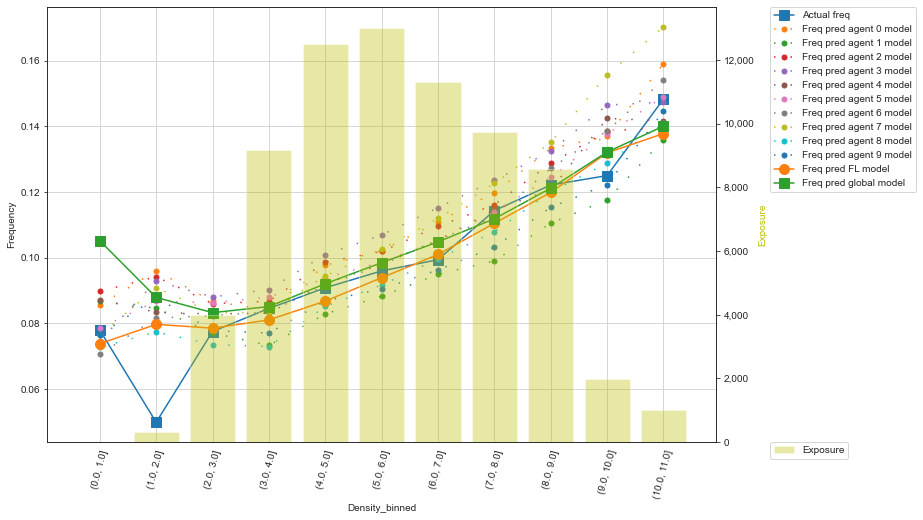

FixedFormatter should only be used together with FixedLocator


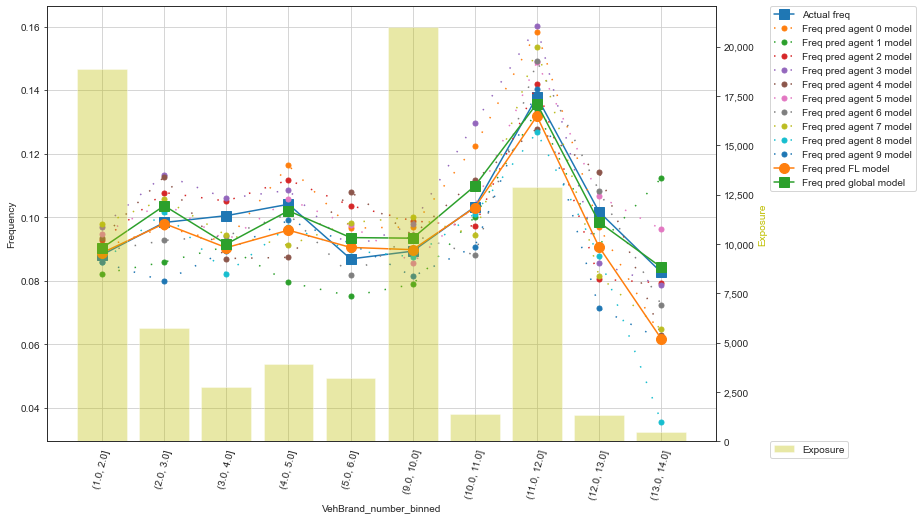

FixedFormatter should only be used together with FixedLocator


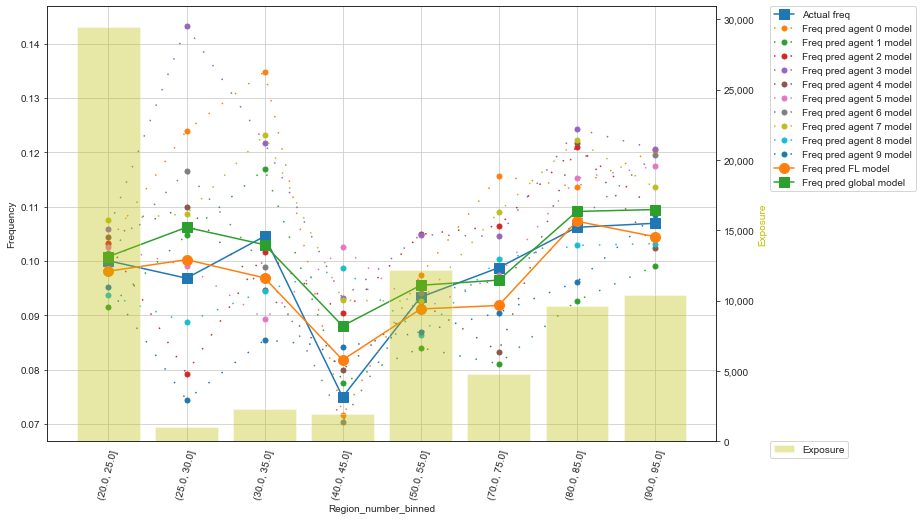

In [927]:
for i in ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']:
    one_way_graph_comparison(i, NUM_AGENTS)

# Gini

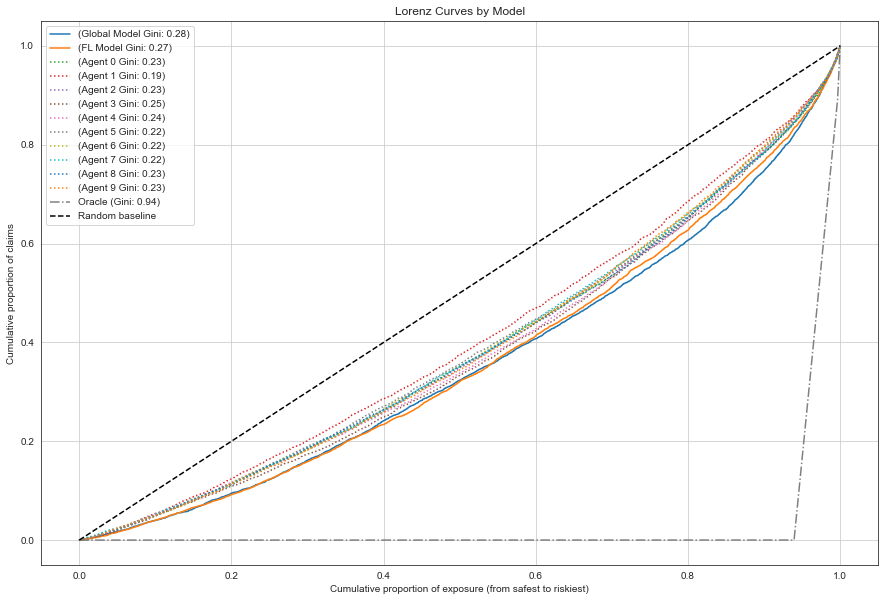

In [928]:
fig, ax = plt.subplots(figsize=(15, 10))

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(Global Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_fl_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(FL Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

for agents in range(NUM_AGENTS):
    cum_exposure, cum_claims = utils.lorenz_curve(
        df_test_pred['ClaimNb'], df_test_pred['ClaimNb_agent_'+str(agents)+'_pred'], df_test_pred["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = '(Agent {} Gini: {:.2f})'.format(agents, gini)
    plt.plot(cum_exposure, cum_claims, linestyle="dotted", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves by Model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)

plt.grid()
ax.legend(loc="upper left")

#plt.savefig(f'../ag_{ag}/' + 'lift_chart')

# Metric comparison

In [929]:
y_fl_pred = df_test['ClaimNb_fl_pred']

In [930]:
fl_weighted_pde = d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)
fl_weighted_pde 

0.04798658304504588

In [931]:
y_global_pred = df_test['ClaimNb_pred']
global_weighted_pde = d2_tweedie_score(y_test, y_global_pred, sample_weight=X_test[:, 0], power=1)
global_weighted_pde 

0.05266257485147674

In [932]:
weighted_pde_df = top_results_df[['agent', 'test_weighted_pde']]
weighted_pde_df

agent  test_weighted_pde
0       -1           0.052663
15       0           0.032799
30       1           0.022663
45       2           0.031960
60       3           0.033799
75       4           0.033175
90       5           0.031399
105      6           0.031232
120      7           0.032742
135      8           0.033491
150      9           0.031985

In [933]:
weighted_pde_df.loc[151] = [-2, d2_tweedie_score(y_test, y_fl_pred, sample_weight=X_test[:, 0], power=1)]
weighted_pde_df


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


agent  test_weighted_pde
0     -1.0           0.052663
15     0.0           0.032799
30     1.0           0.022663
45     2.0           0.031960
60     3.0           0.033799
75     4.0           0.033175
90     5.0           0.031399
105    6.0           0.031232
120    7.0           0.032742
135    8.0           0.033491
150    9.0           0.031985
151   -2.0           0.047987

In [934]:
weighted_pde_df['fl_relative_increase'] = fl_weighted_pde/weighted_pde_df['test_weighted_pde'] - 1
weighted_pde_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


agent  test_weighted_pde  fl_relative_increase
0     -1.0           0.052663             -0.088792
15     0.0           0.032799              0.463061
30     1.0           0.022663              1.117444
45     2.0           0.031960              0.501458
60     3.0           0.033799              0.419768
75     4.0           0.033175              0.446480
90     5.0           0.031399              0.528278
105    6.0           0.031232              0.536446
120    7.0           0.032742              0.465579
135    8.0           0.033491              0.432810
150    9.0           0.031985              0.500267
151   -2.0           0.047987              0.000000

In [935]:
weighted_pde_df['model'] = 'Agent'+' '+weighted_pde_df['agent'].astype(int).apply(str)
weighted_pde_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


agent  test_weighted_pde  fl_relative_increase     model
0     -1.0           0.052663             -0.088792  Agent -1
15     0.0           0.032799              0.463061   Agent 0
30     1.0           0.022663              1.117444   Agent 1
45     2.0           0.031960              0.501458   Agent 2
60     3.0           0.033799              0.419768   Agent 3
75     4.0           0.033175              0.446480   Agent 4
90     5.0           0.031399              0.528278   Agent 5
105    6.0           0.031232              0.536446   Agent 6
120    7.0           0.032742              0.465579   Agent 7
135    8.0           0.033491              0.432810   Agent 8
150    9.0           0.031985              0.500267   Agent 9
151   -2.0           0.047987              0.000000  Agent -2

In [936]:
weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -1','Global Model')
weighted_pde_df['model'] = weighted_pde_df['model'].str.replace('Agent -2','Federated Model')
weighted_pde_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


agent  test_weighted_pde  fl_relative_increase            model
0     -1.0           0.052663             -0.088792     Global Model
15     0.0           0.032799              0.463061          Agent 0
30     1.0           0.022663              1.117444          Agent 1
45     2.0           0.031960              0.501458          Agent 2
60     3.0           0.033799              0.419768          Agent 3
75     4.0           0.033175              0.446480          Agent 4
90     5.0           0.031399              0.528278          Agent 5
105    6.0           0.031232              0.536446          Agent 6
120    7.0           0.032742              0.465579          Agent 7
135    8.0           0.033491              0.432810          Agent 8
150    9.0           0.031985              0.500267          Agent 9
151   -2.0           0.047987              0.000000  Federated Model

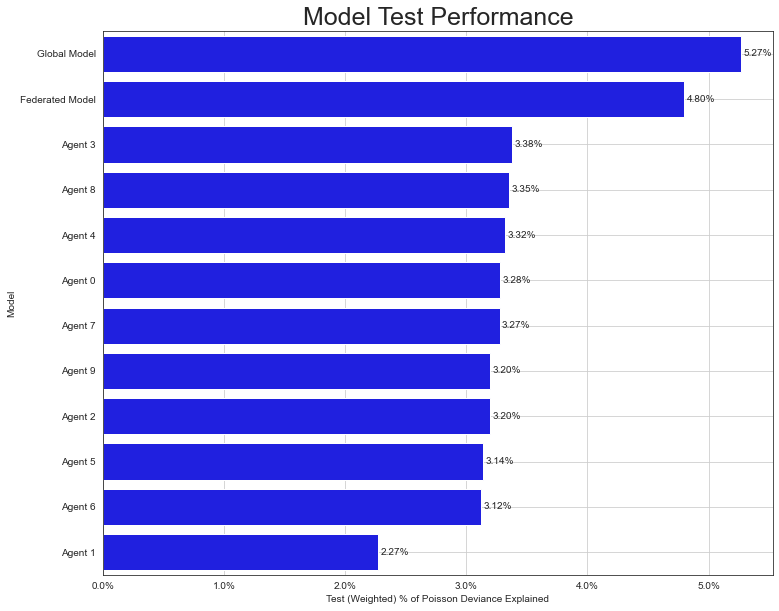

In [937]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(y='model', 
               x='test_weighted_pde',
               data=weighted_pde_df.iloc[0:,:].sort_values(by=['test_weighted_pde'], ascending = False),
               orient='h',
               color='blue',
               )
plt.title('Model Test Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Test (Weighted) % of Poisson Deviance Explained', fontsize=10)
plt.ylabel('Model', fontsize=10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
#ax.axvline(global_weighted_pde, ls='--')
#ax.annotate('Global Model Test Performance', xy=(global_weighted_pde, -0.5), horizontalalignment='center', weight='semibold', size='medium')
for i in range(12):
    ax.text(round(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[0+i:1+i,1],4).tolist()[0]+0.0002, 
            i, 
            '{:.2%}'.format(round(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[0+i:1+i,1],4).tolist()[0]),
            verticalalignment='center',
            fontdict=(dict(fontsize=10)))
ax.grid(True)
plt.show()

# SHAP

In [817]:
import shap

In [873]:
background = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]

In [880]:
# Define architecture (OPTUNA ARCHITECTURE)
class MultipleRegression(nn.Module):
    def __init__(self, num_features=39, 
                 num_units_1=40, 
                 num_units_2=60, 
                 #num_units_3=60,
                 activation=nn.Tanh, 
                 dropout_rate=0):
        super(MultipleRegression, self).__init__()
        
        self.act1 = activation()
        self.act2 = activation()

        self.layers = nn.Sequential(
        nn.Linear(num_features, num_units_1),
        self.act1,
        nn.Linear(num_units_1, num_units_2),
        self.act2,
        nn.Linear(num_units_2, 1)
        )
    
    def forward(self, x):
        return th.exp(self.layers(x))

In [881]:
fl_model = MultipleRegression(num_features=NUM_FEATURES, num_units_1=FL_NUM_UNITS_1, num_units_2=FL_NUM_UNITS_2)
fl_model.load_state_dict(th.load(FL_PATH))
fl_model.eval()
fl_model

RuntimeError: Error(s) in loading state_dict for MultipleRegression:
	Missing key(s) in state_dict: "layers.0.weight", "layers.0.bias", "layers.2.weight", "layers.2.bias", "layers.4.weight", "layers.4.bias". 
	Unexpected key(s) in state_dict: "layer_1.weight", "layer_1.bias", "layer_2.weight", "layer_2.bias", "layer_out.weight", "layer_out.bias". 

In [885]:
type(loaded_agent_7_model)

skorch.regressor.NeuralNetRegressor

In [887]:
type(fl_model)

__main__.MultipleRegression

In [888]:
e = shap.DeepExplainer(fl_model, th.from_numpy(background).float())

In [889]:
shap_values = e.shap_values(th.from_numpy(X_test).float())

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [890]:
shap_values

array([[ 0.00851402,  0.01611065,  0.00358271, ..., -0.00234002,
         0.00443898, -0.0002841 ],
       [ 0.0023982 ,  0.00233642, -0.0010105 , ..., -0.00230699,
         0.00433386, -0.00027608],
       [-0.00236671, -0.00463062, -0.00411752, ..., -0.00233817,
         0.00439797, -0.00028482],
       ...,
       [-0.01123427, -0.00471195, -0.00104465, ..., -0.00226147,
         0.00443249, -0.00027984],
       [-0.00577908, -0.01164428,  0.00230991, ..., -0.00226363,
         0.00427273, -0.00027109],
       [-0.00707139,  0.00929364, -0.00544349, ..., -0.00232398,
         0.00408765, -0.00027232]])

In [893]:
shap_obj = e(th.from_numpy(X_test).float())

AttributeError: 'Deep' object has no attribute 'masker'

In [891]:
shap.plots.beeswarm(shap_values)

TypeError: The beeswarm plot requires an `Explanation` object as the `shap_values` argument.

# PDPs

In [938]:
def plot_partial_dependency(bst, X, y, f_id):

    X_temp = X.copy()

    x_scan = np.linspace(np.percentile(X_temp[:, f_id], 0.1), np.percentile(X_temp[:, f_id], 99.5), 50)
    y_partial = []

    feature =  df_test.columns[f_id]

    for point in x_scan:

        X_temp[:, f_id] = point

        #dpartial = xgb.DMatrix(X_temp[:, feature_ids])

        # Global Model Predictions
        #y_pred = global_model.predict(X_test.astype(np.float64))
        
        #y_partial.append(np.average(bst.predict(X_temp)))
        y_partial.append(np.average(bst.predict(X_temp.astype(np.float64))))

    y_partial = np.array(y_partial)

    # Plot partial dependence

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 10)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(x_scan, y_partial, '-', color = 'black', linewidth = 1)
    #ax.plot(X[:, f_id], y, 'o', color = 'blue', alpha = 0.02)

    ax.set_xlim(min(x_scan), max(x_scan))
    ax.set_xlabel(feature, fontsize = 12)    
    ax.set_ylabel('Partial Dependence', fontsize = 12)

    #plt.title(bst, fontsize=25)

    ax.grid(True)
    
    plt.show()

In [939]:
df_test

Exposure  Area  VehPower  VehAge  DrivAge  BonusMalus  VehGas  \
0       1.000000   1.0       4.0    11.0     45.0        50.0     1.0   
1       0.700000   3.0       7.0     3.0     26.0        68.0     1.0   
2       0.460000   4.0       9.0    15.0     21.0        95.0     1.0   
3       0.450000   5.0       4.0     0.0     69.0        50.0     1.0   
4       0.490000   6.0       9.0     1.0     57.0        50.0     1.0   
...          ...   ...       ...     ...      ...         ...     ...   
135598  0.070000   3.0       9.0     0.0     53.0        50.0     1.0   
135599  0.110000   3.0       9.0    16.0     37.0        50.0     1.0   
135600  0.008219   4.0       7.0     0.0     56.0        50.0     1.0   
135601  0.280000   5.0       5.0    17.0     50.0        90.0     1.0   
135602  0.210000   2.0      10.0     5.0     68.0        50.0     2.0   

          Density VehBrand Region  ...  ClaimNb_agent_1_pred  \
0        2.197225       B3    R24  ...              0.042075   
1        5.774552       B6    R31  ...              0.051672   
2        6.960348       B3    R24  ...              0.045571   
3        8.325548      B12    R52  ...              0.061431   
4       10.060320       B2    R21  ...              0.054367   
...           ...      ...    ...  ...                   ...   
135598   5.953243      B12    R82  ...              0.045180   
135599   6.003887      B14    R24  ...              0.034377   
135600   6.628041      B12    R26  ...              0.051416   
135601   9.138522       B5    R82  ...              0.049125   
135602   4.430817      B12    R52  ...              0.038523   

        ClaimNb_agent_2_pred  ClaimNb_agent_3_pred ClaimNb_agent_4_pred  \
0                   0.051440              0.039959             0.055563   
1                   0.039081              0.055658             0.055788   
2                   0.057087              0.086093             0.102909   
3                   0.122126              0.169678             0.074739   
4                   0.046061              0.076142             0.049575   
...                      ...                   ...                  ...   
135598              0.081093              0.193779             0.133633   
135599              0.012836              0.006805             0.015661   
135600              0.052124              0.132198             0.126394   
135601              0.074324              0.094622             0.072902   
135602              0.029452              0.029781             0.022526   

       ClaimNb_agent_5_pred ClaimNb_agent_6_pred ClaimNb_agent_7_pred  \
0                  0.054955             0.038182             0.042728   
1                  0.043917             0.063399             0.061582   
2                  0.071018             0.078889             0.073573   
3                  0.168407             0.167799             0.081329   
4                  0.057968             0.053488             0.059809   
...                     ...                  ...                  ...   
135598             0.099936             0.081147             0.114385   
135599             0.015640             0.014955             0.023546   
135600             0.112618             0.065720             0.077842   
135601             0.056019             0.072904             0.044347   
135602             0.030453             0.018290             0.023114   

       ClaimNb_agent_8_pred ClaimNb_agent_9_pred ClaimNb_pred_binned  
0                  0.044594             0.038219     (0.0312, 0.034]  
1                  0.056204             0.045108    (0.0578, 0.0589]  
2                  0.074718             0.060034     (0.0763, 0.105]  
3                  0.152713             0.118577       (0.17, 0.542]  
4                  0.049519             0.061873    (0.0564, 0.0578]  
...                     ...                  ...                 ...  
135598             0.089319             0.070066       (0.17, 0.542]  
135599          

Feature 0


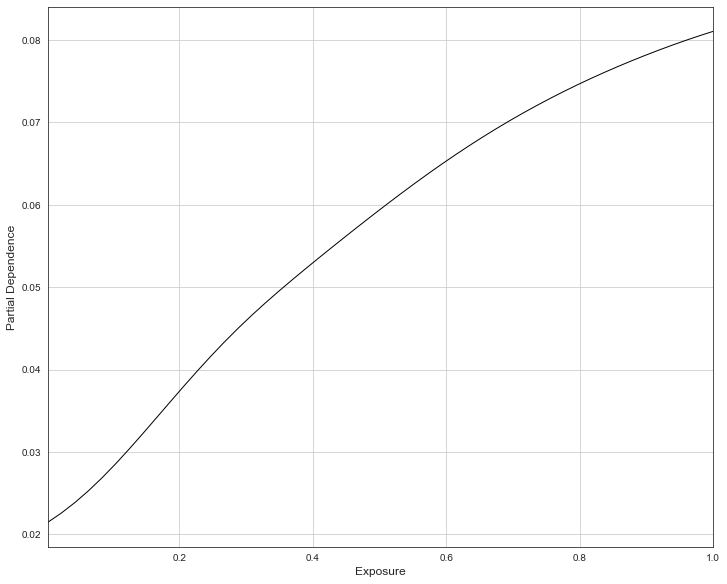

Feature 1


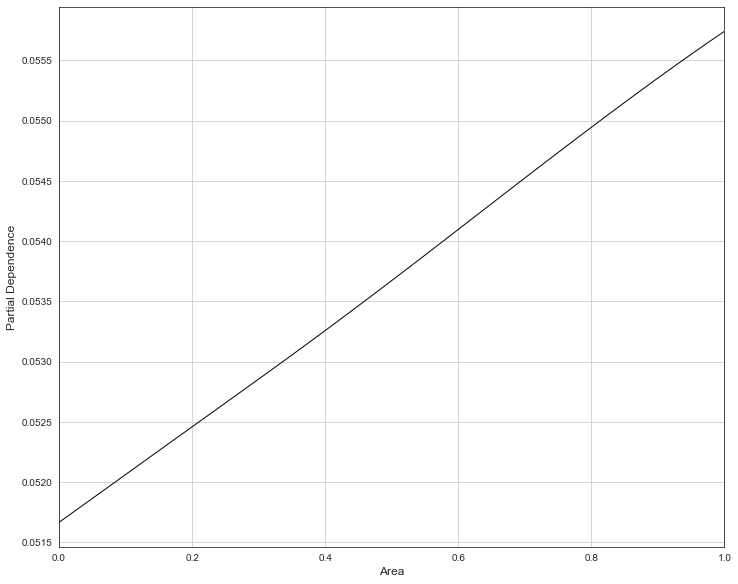

Feature 2


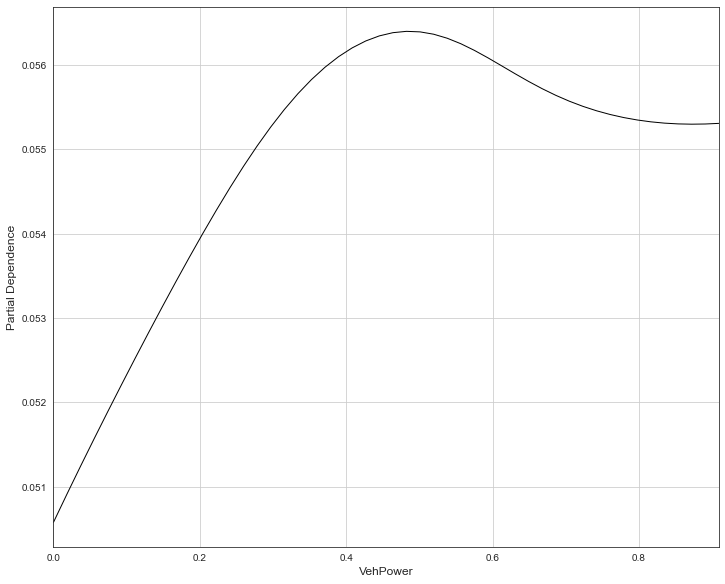

Feature 3


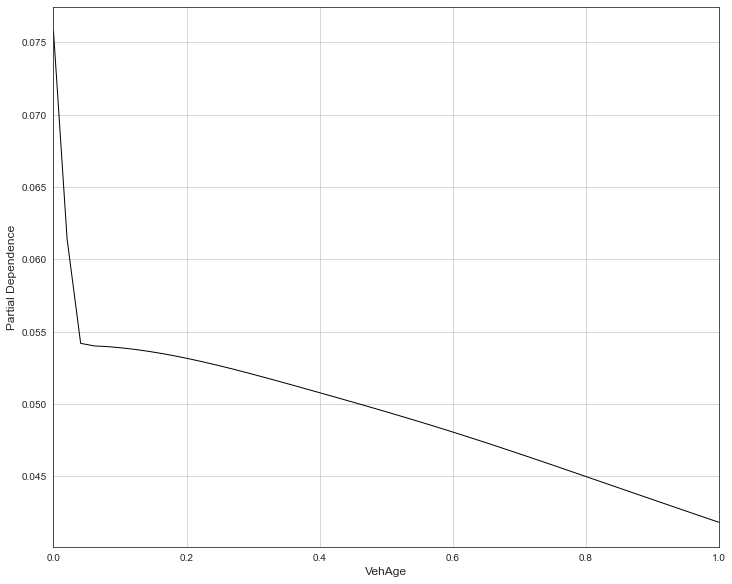

Feature 4


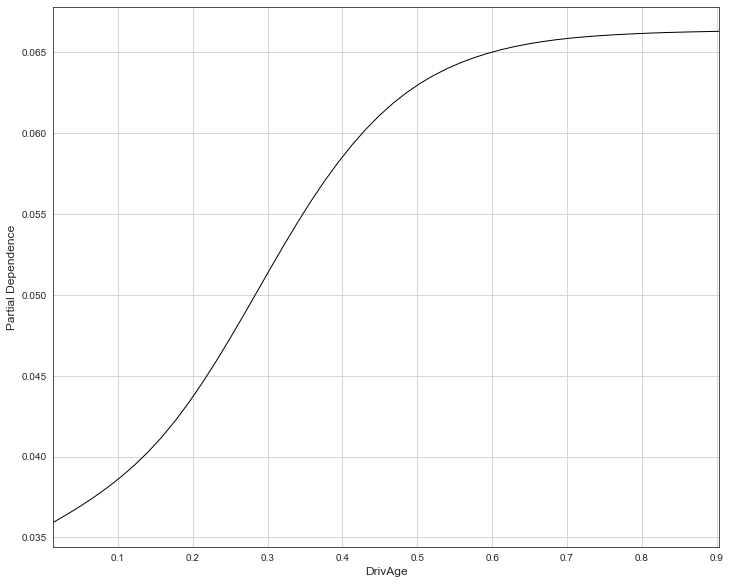

Feature 5


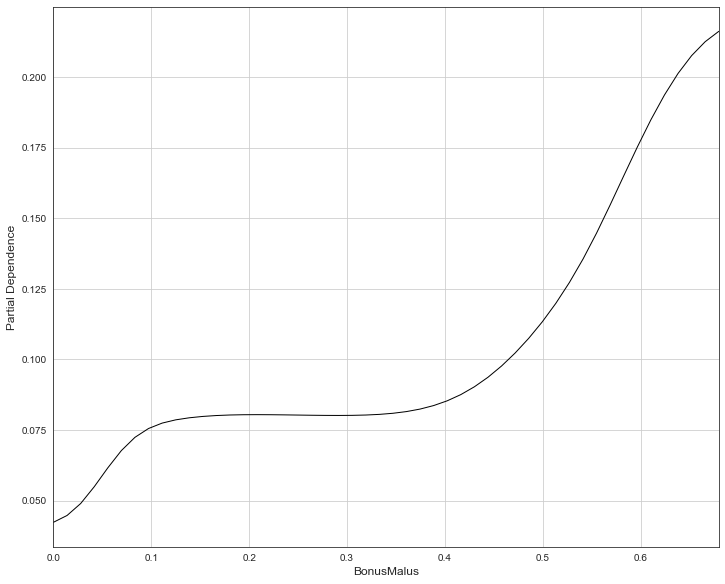

Feature 6


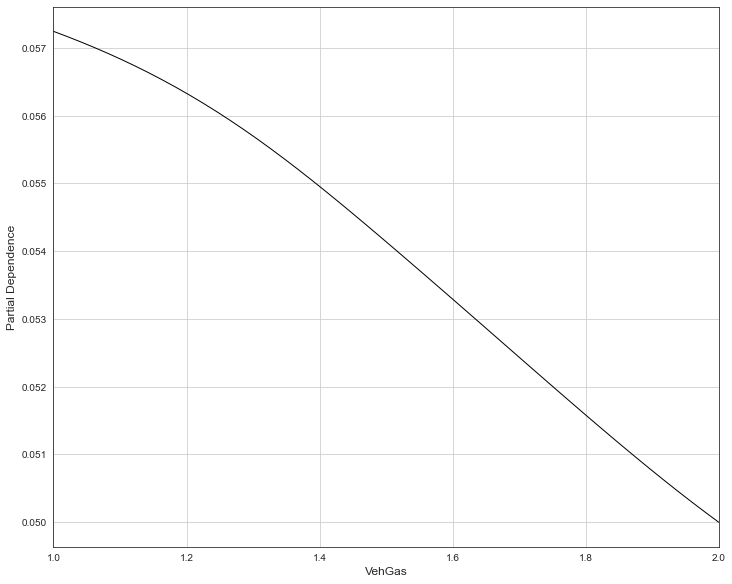

Feature 7


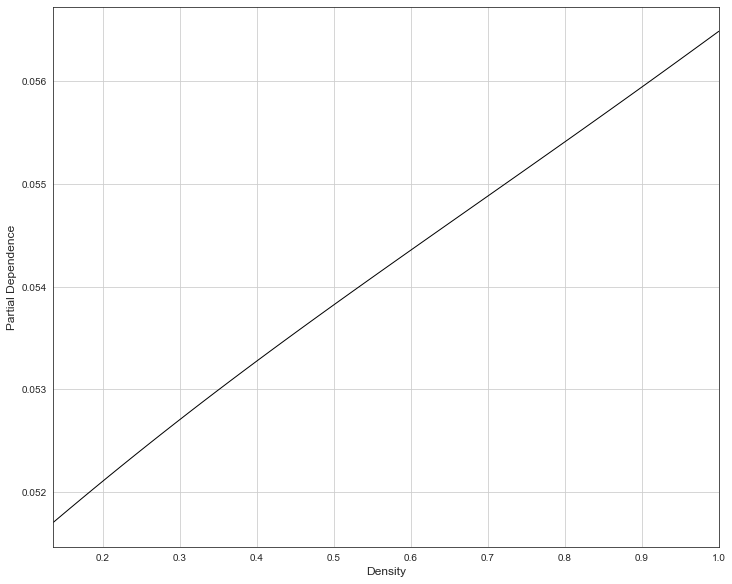

In [940]:
for i in range(0,8):
    print('Feature '+str(i))
    plot_partial_dependency(loaded_agent_global_model, X_test, y_test, i)

Feature 0
Agent 0


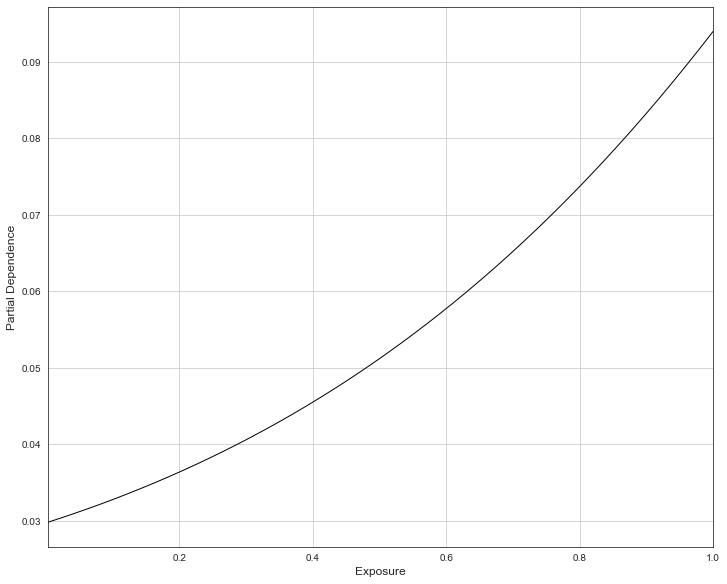

Agent 1


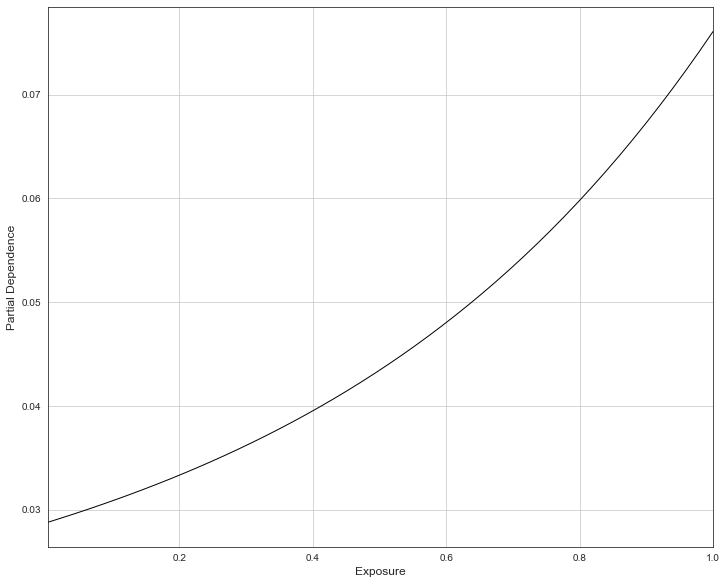

Agent 2


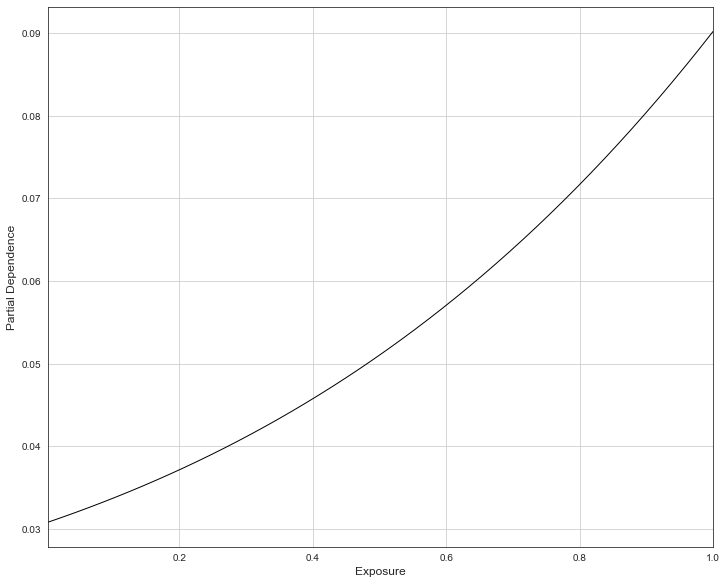

Agent 3


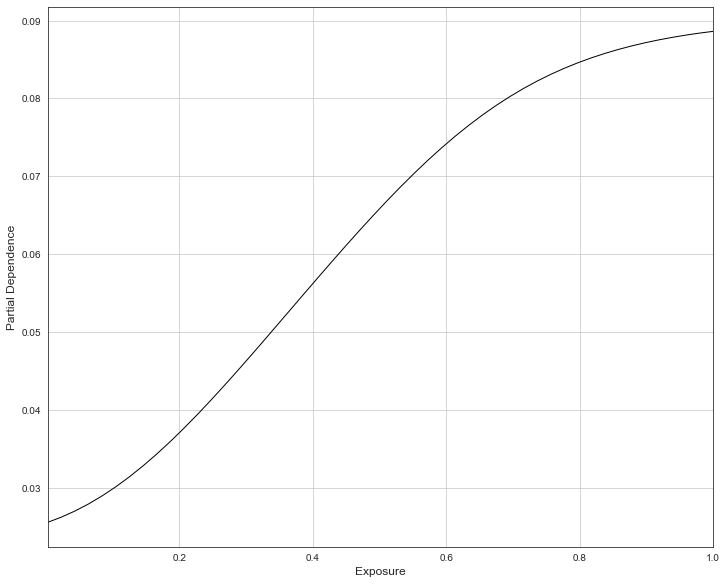

Agent 4


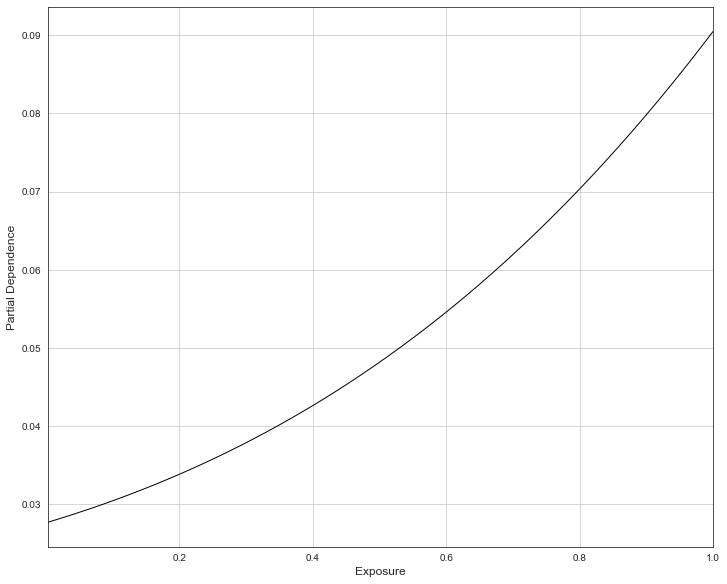

Agent 5


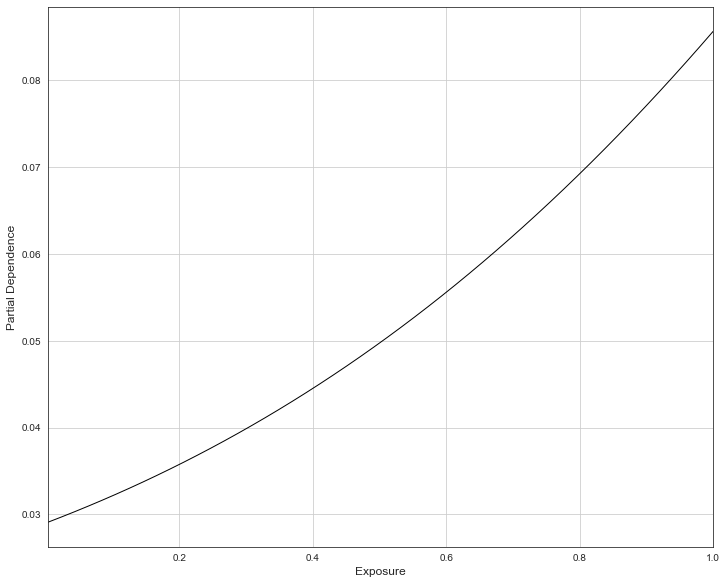

Agent 6


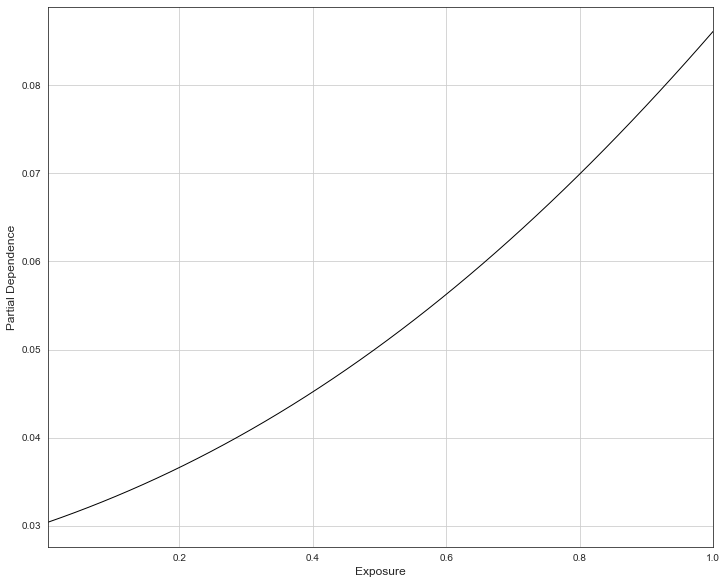

Agent 7


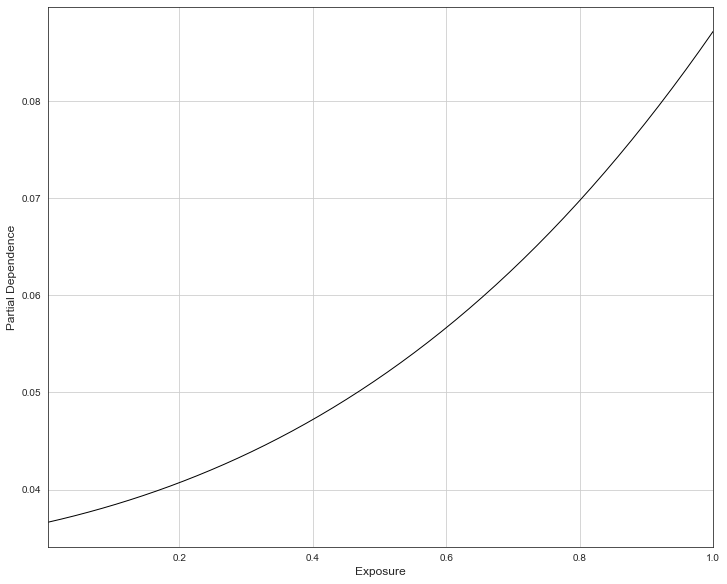

Agent 8


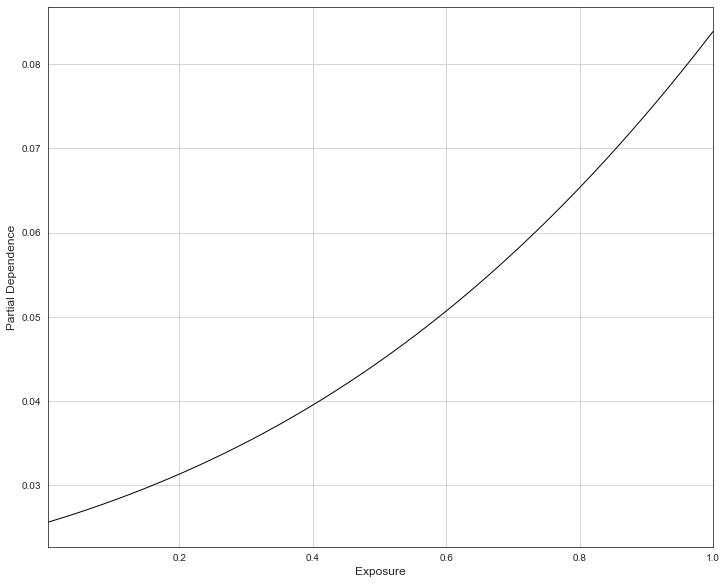

Agent 9


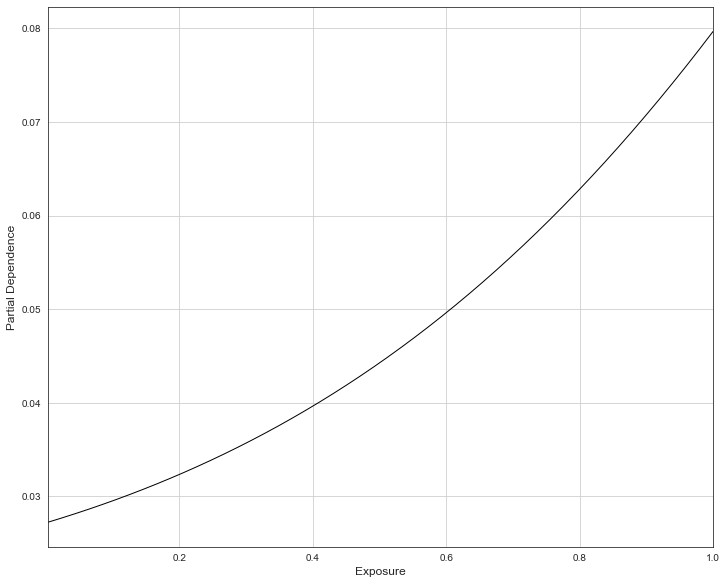

Feature 1
Agent 0


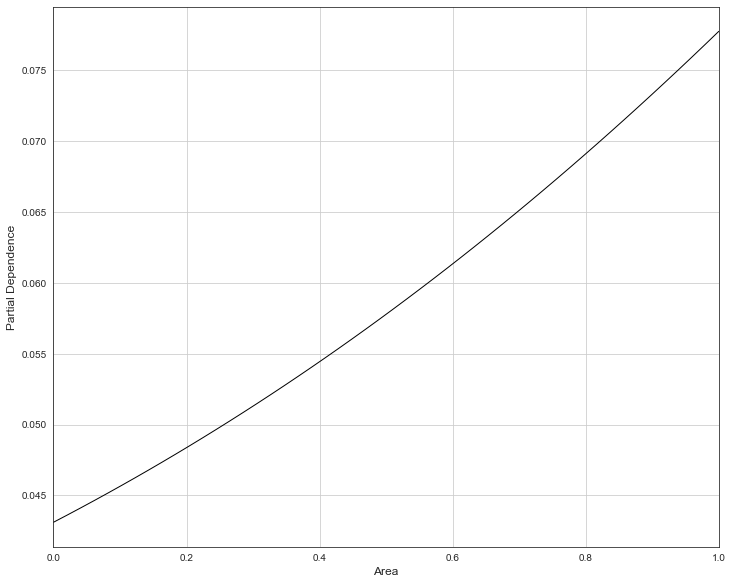

Agent 1


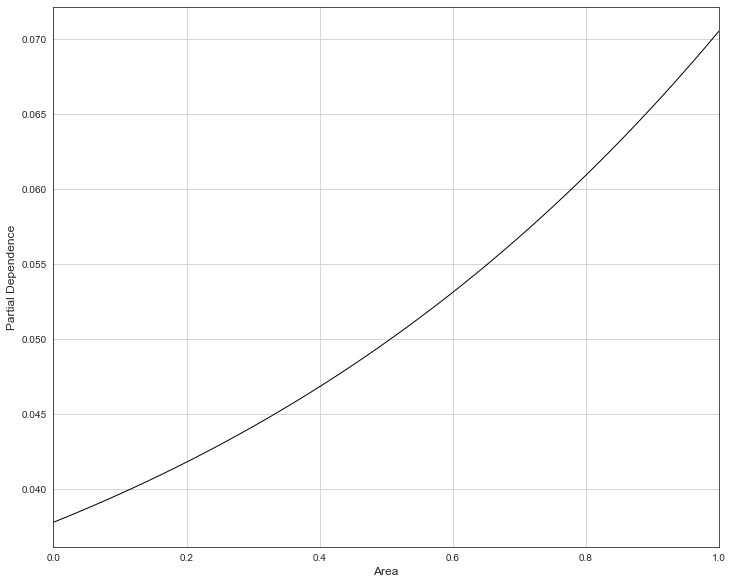

Agent 2


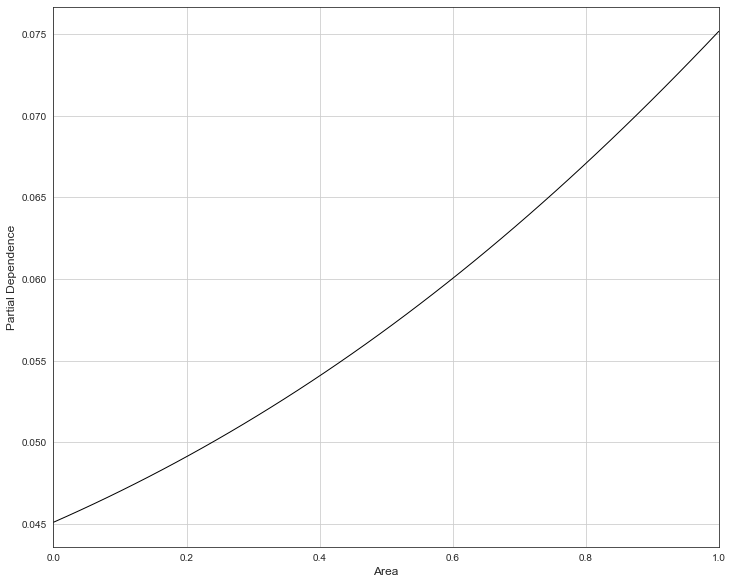

Agent 3


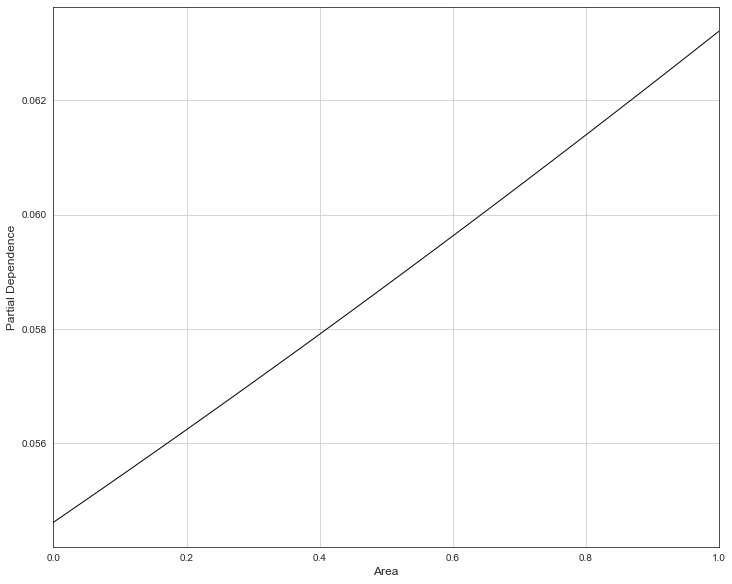

Agent 4


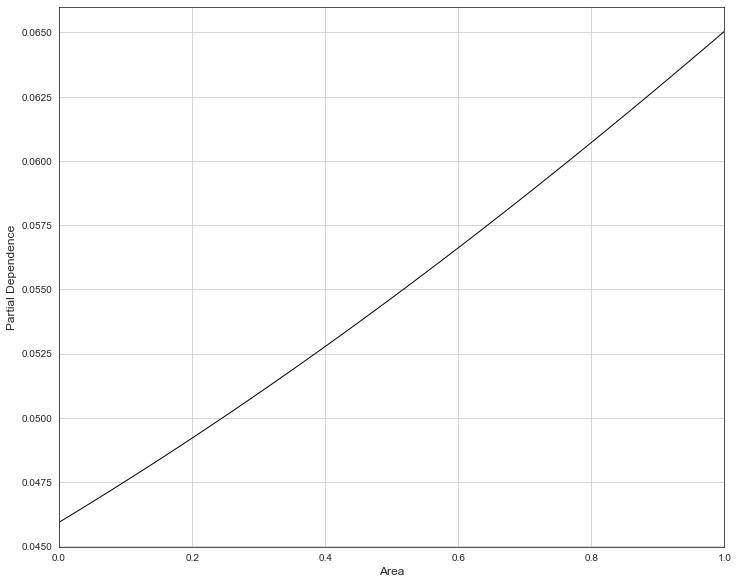

Agent 5


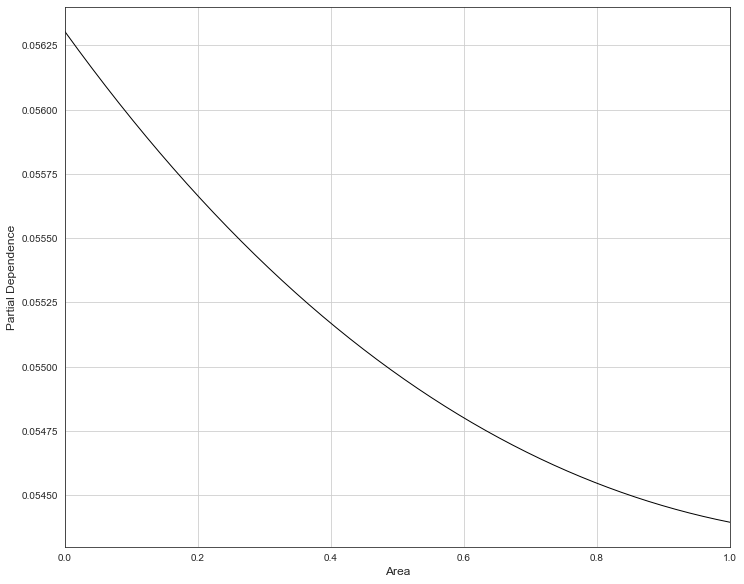

Agent 6


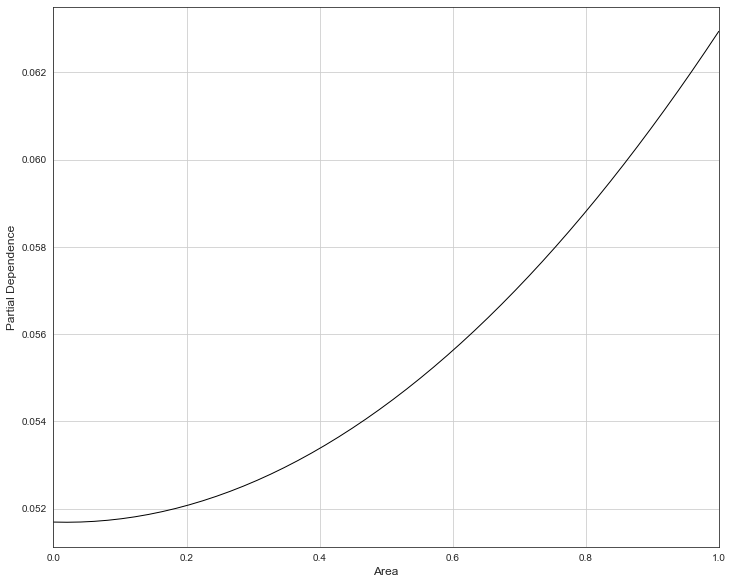

Agent 7


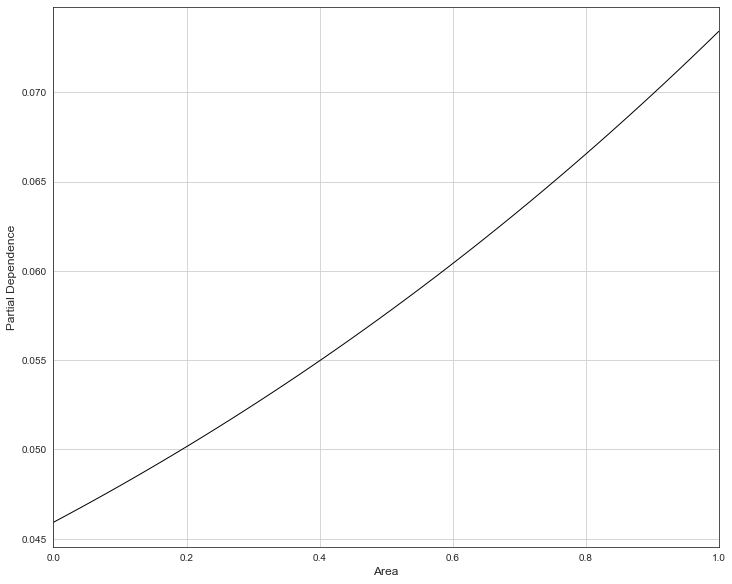

Agent 8


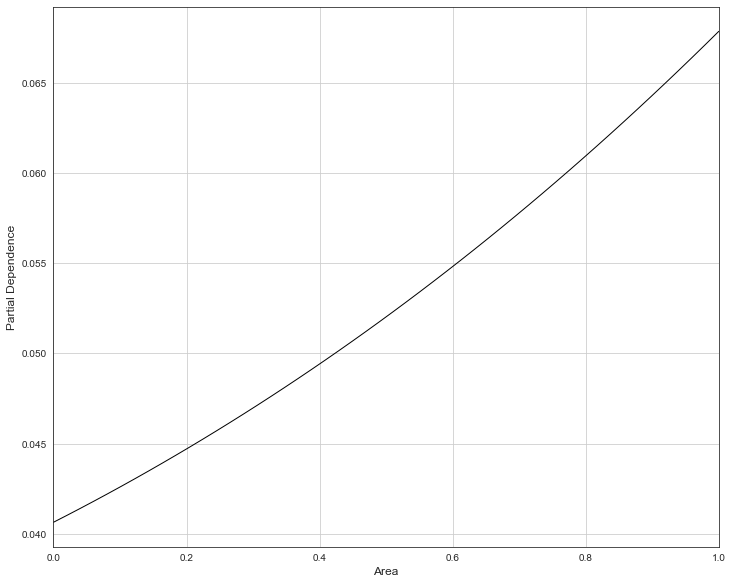

Agent 9


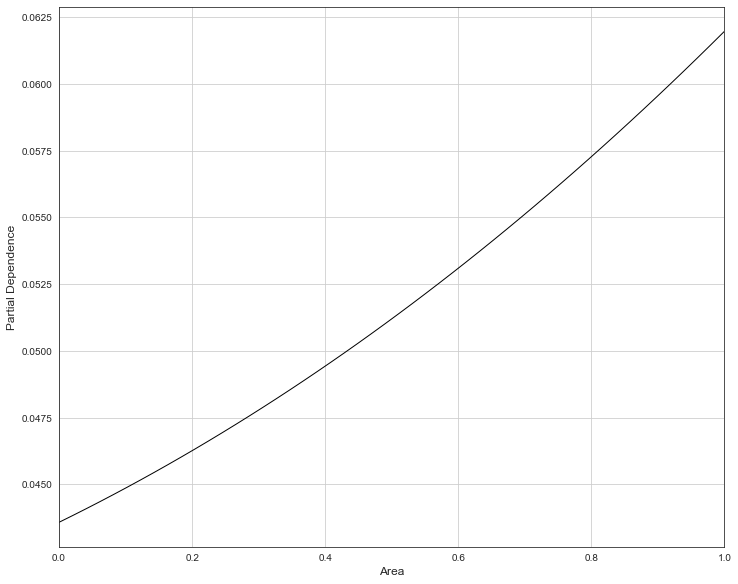

Feature 2
Agent 0


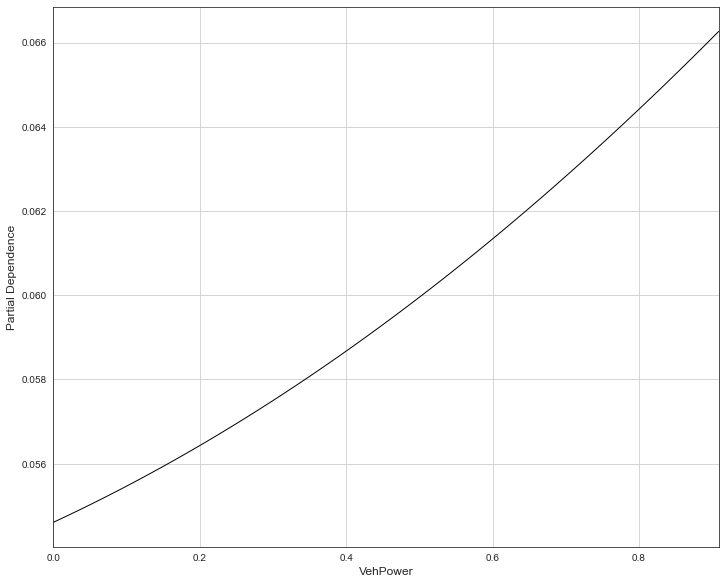

Agent 1


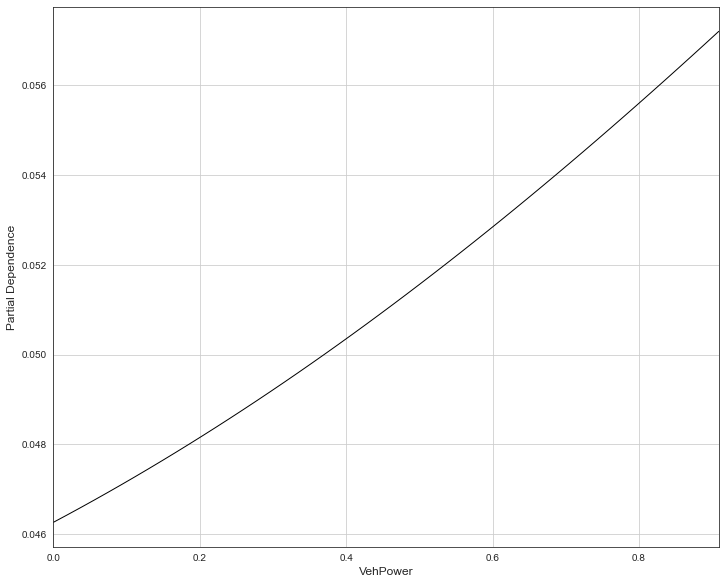

Agent 2


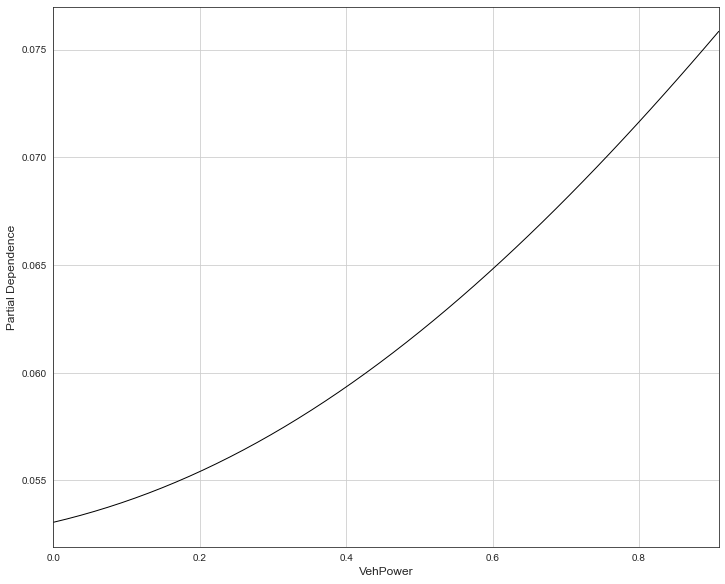

Agent 3


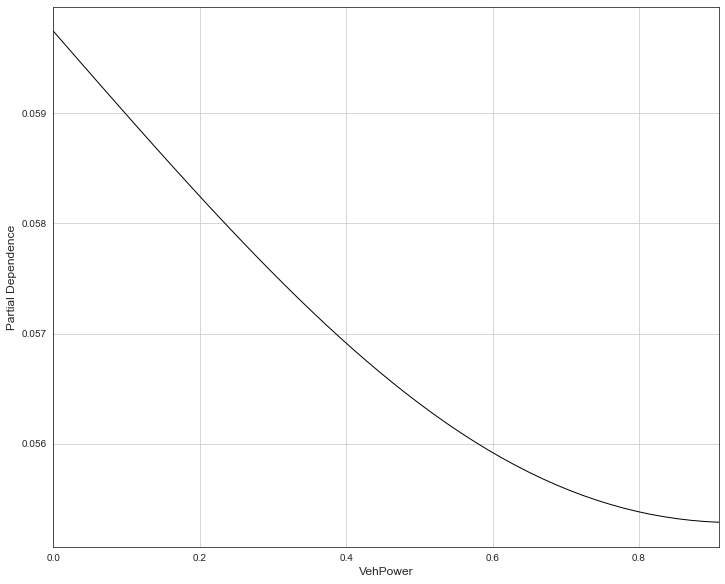

Agent 4


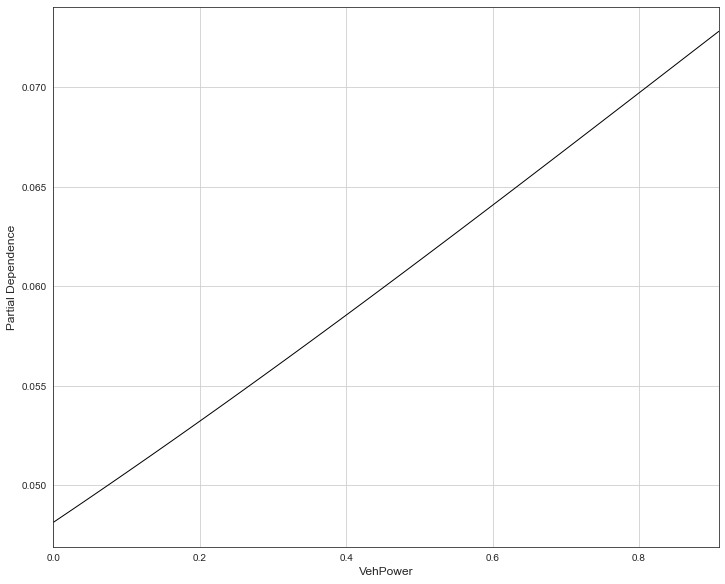

Agent 5


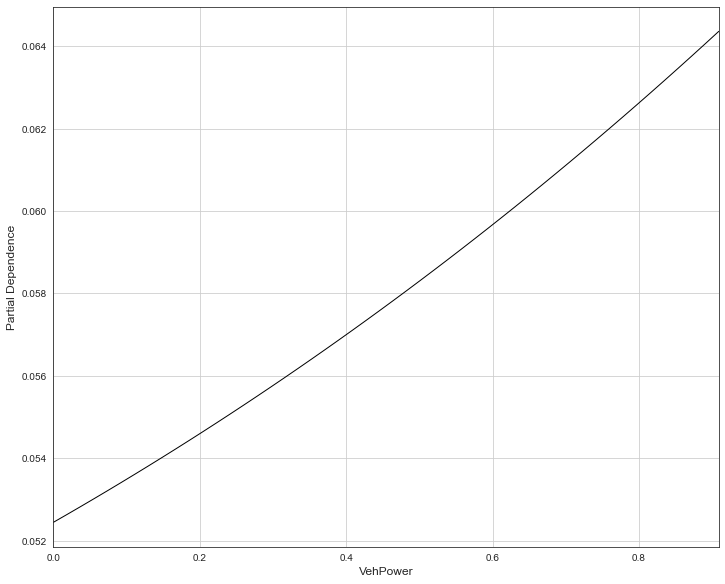

Agent 6


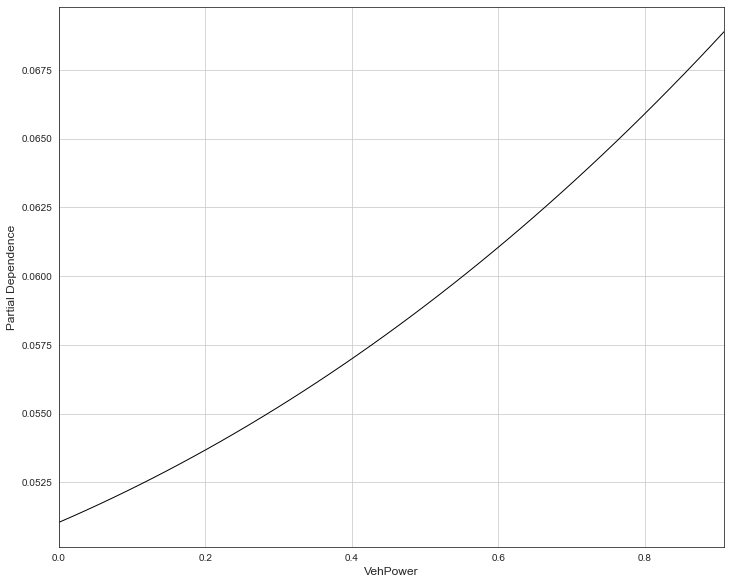

Agent 7


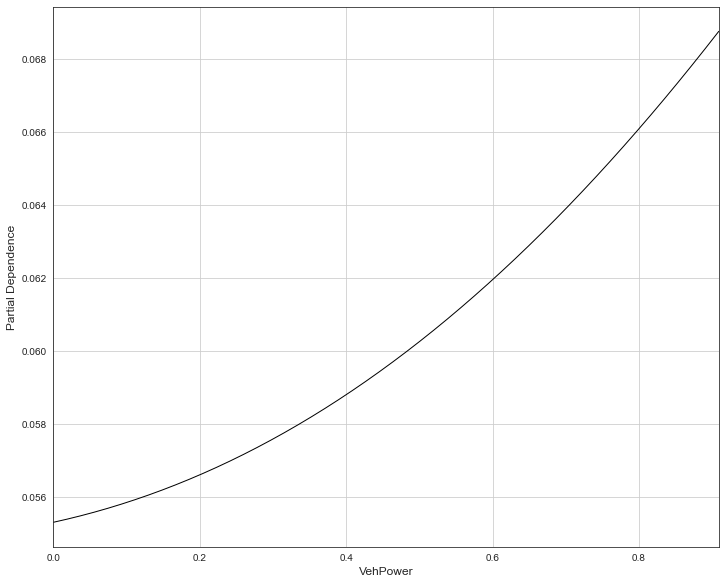

Agent 8


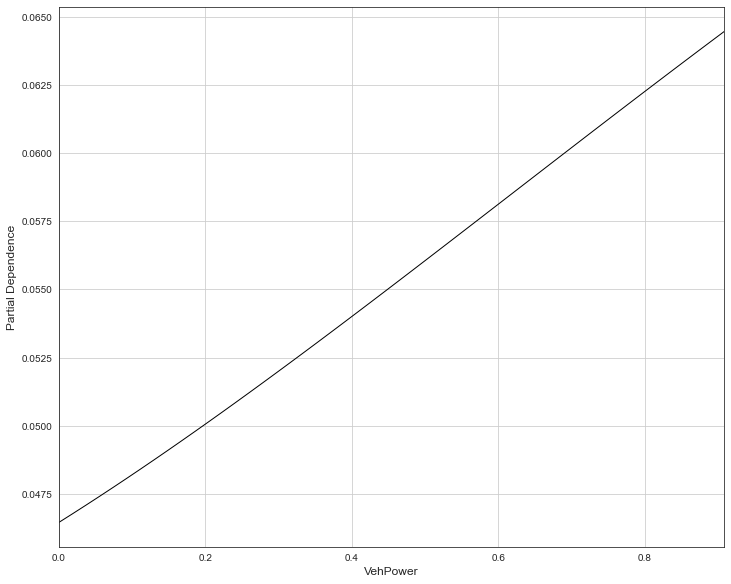

Agent 9


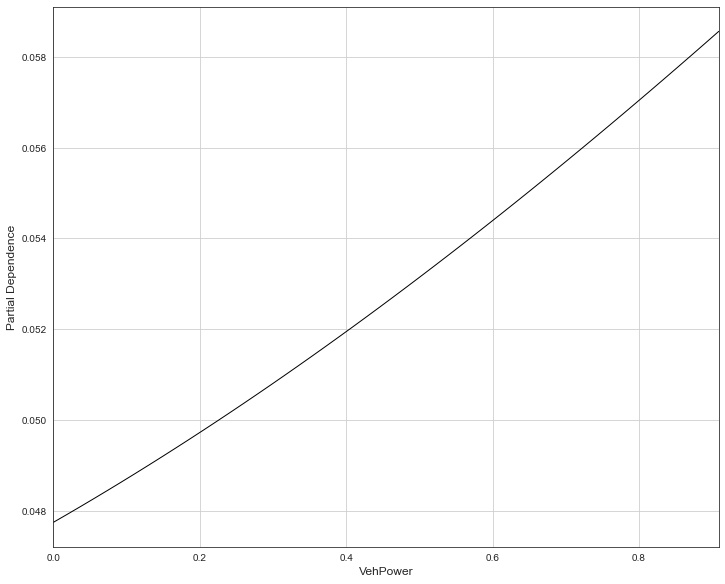

Feature 3
Agent 0


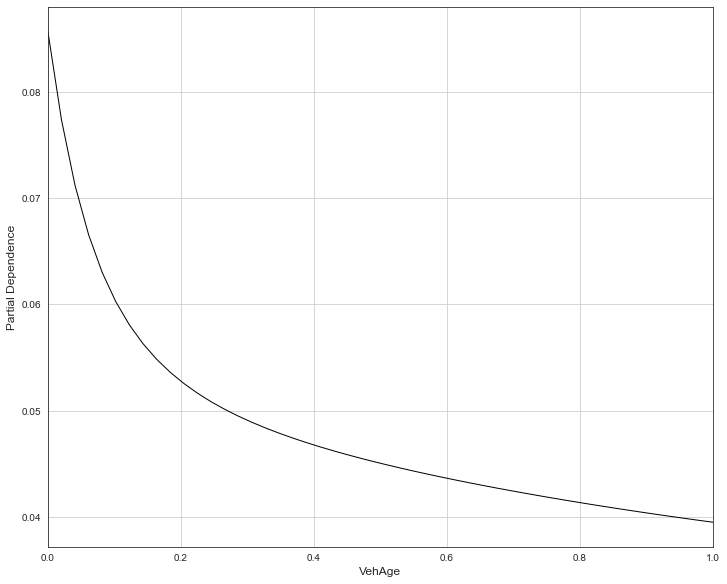

Agent 1


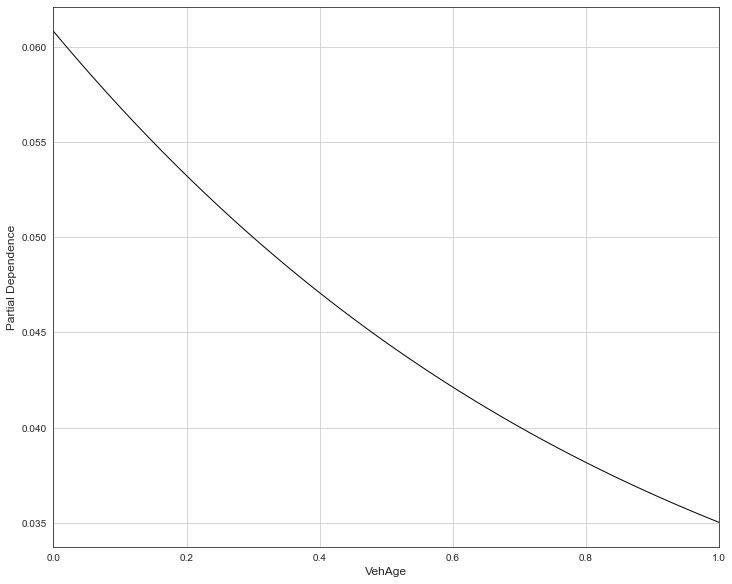

Agent 2


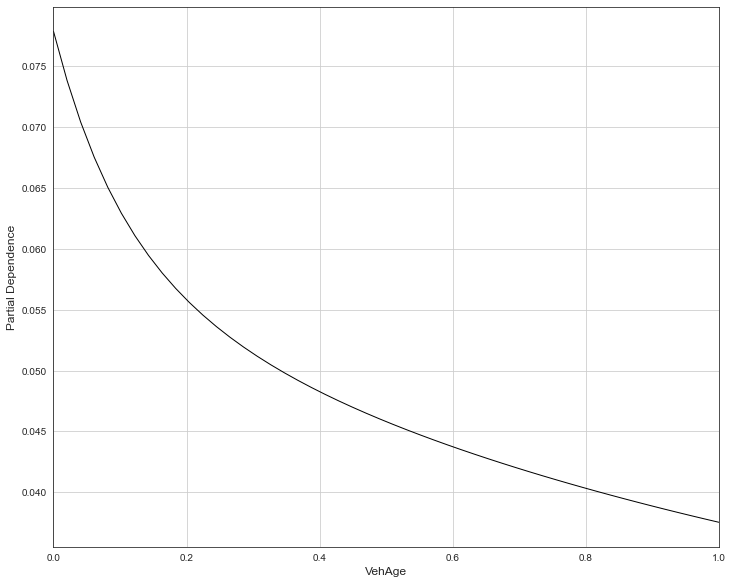

Agent 3


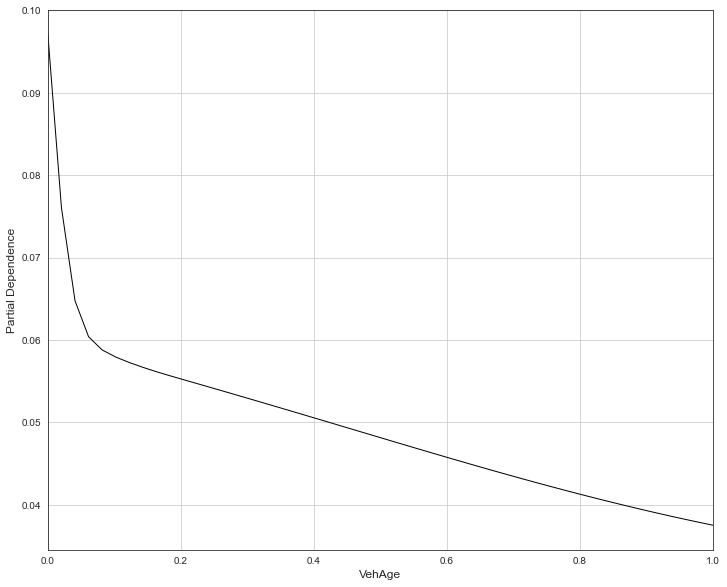

Agent 4


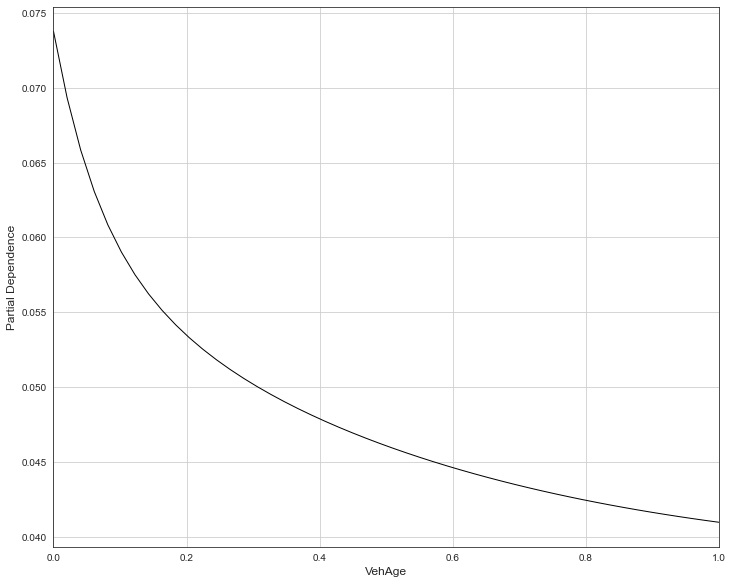

Agent 5


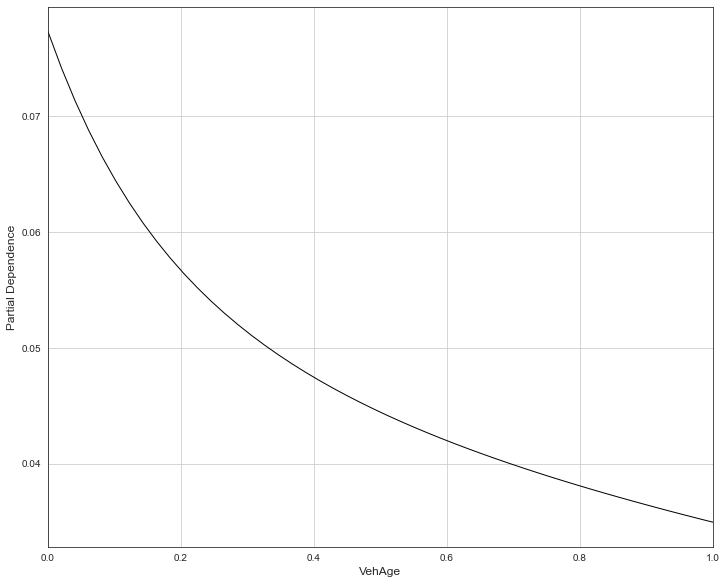

Agent 6


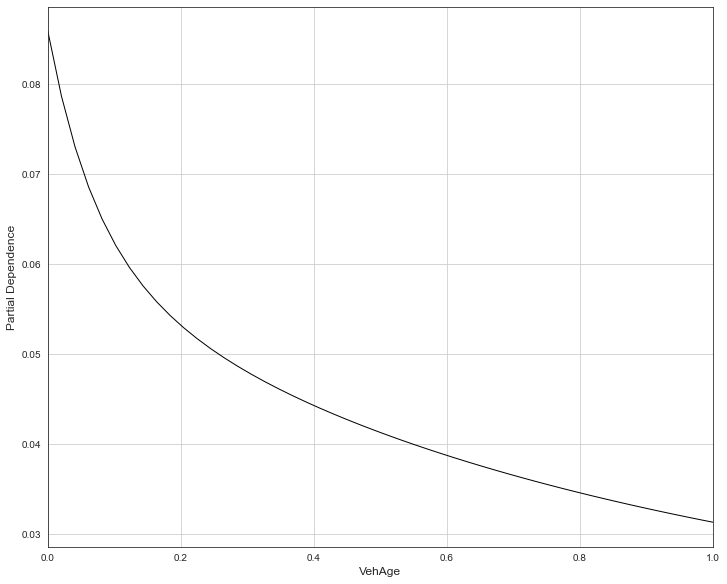

Agent 7


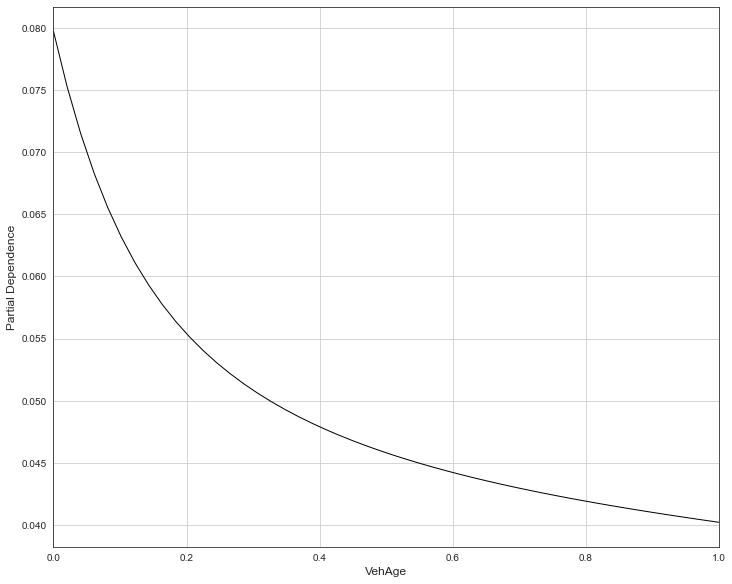

Agent 8


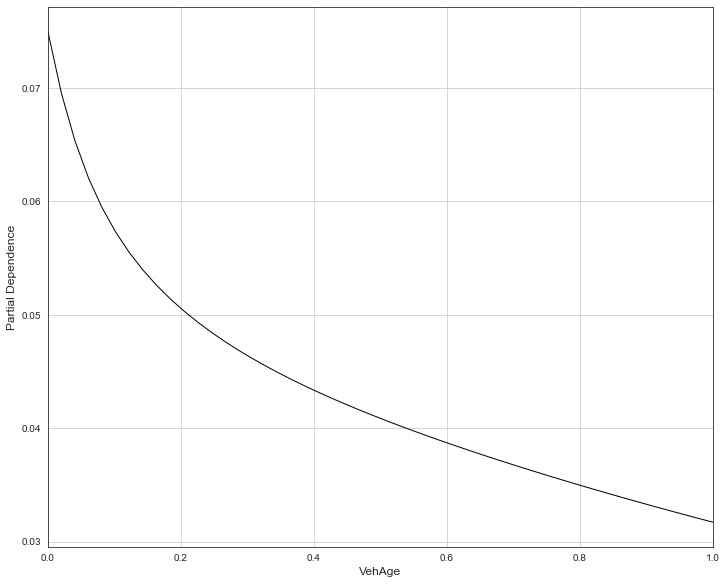

Agent 9


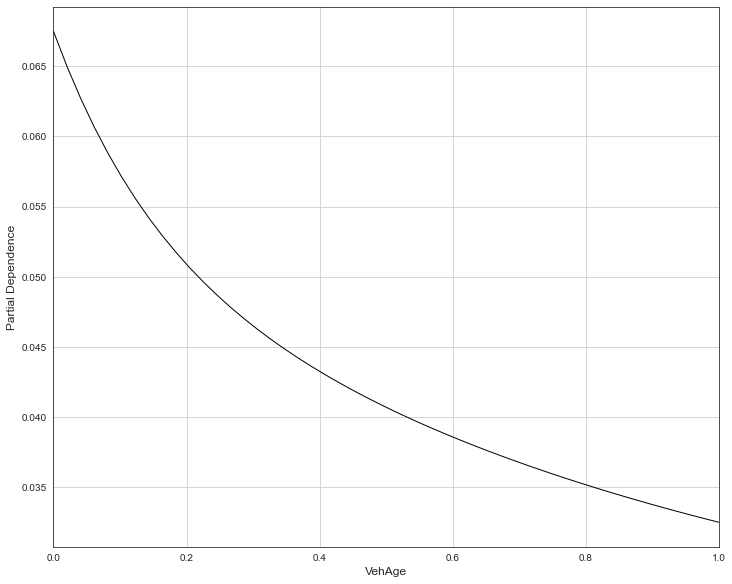

Feature 4
Agent 0


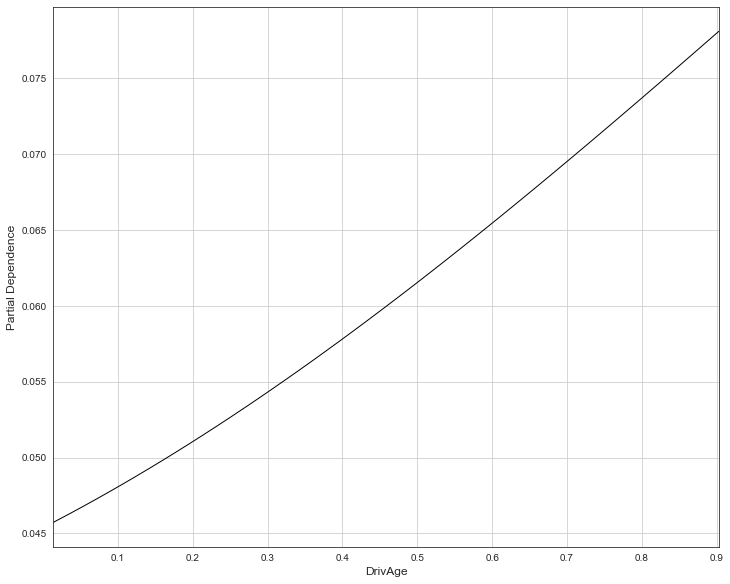

Agent 1


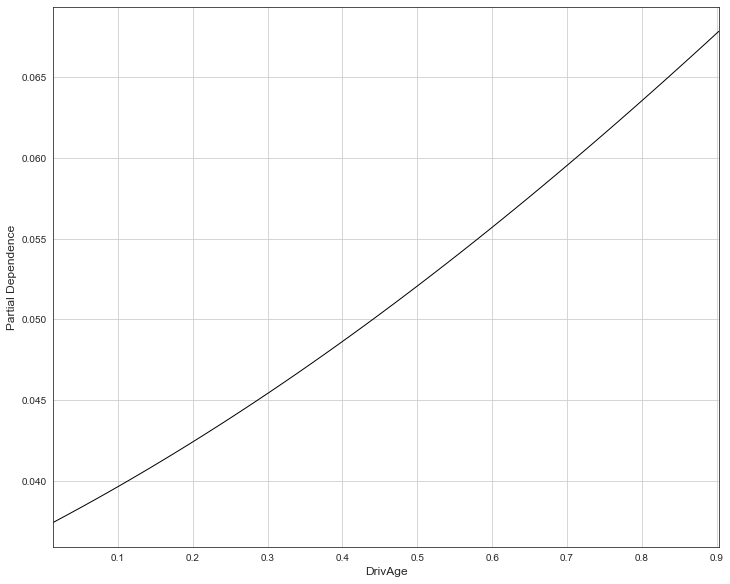

Agent 2


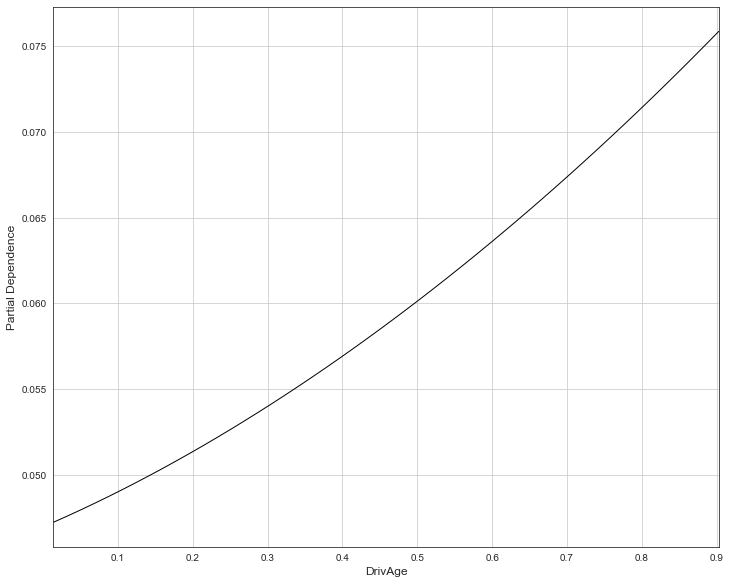

Agent 3


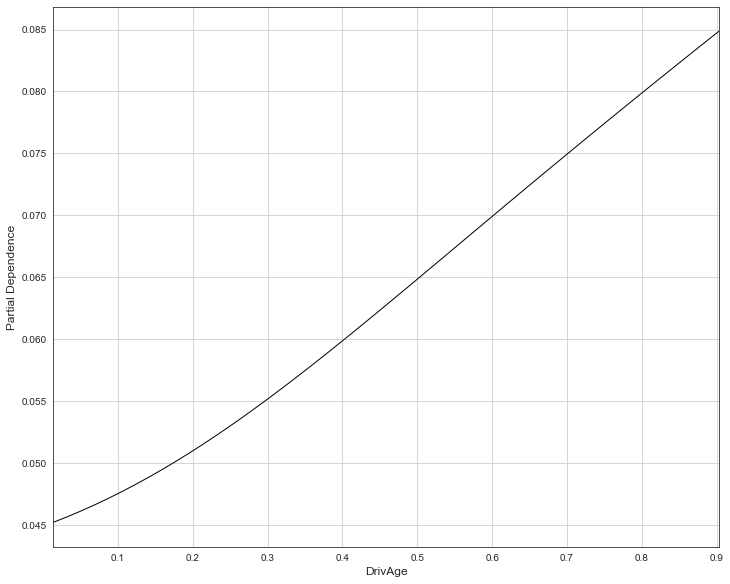

Agent 4


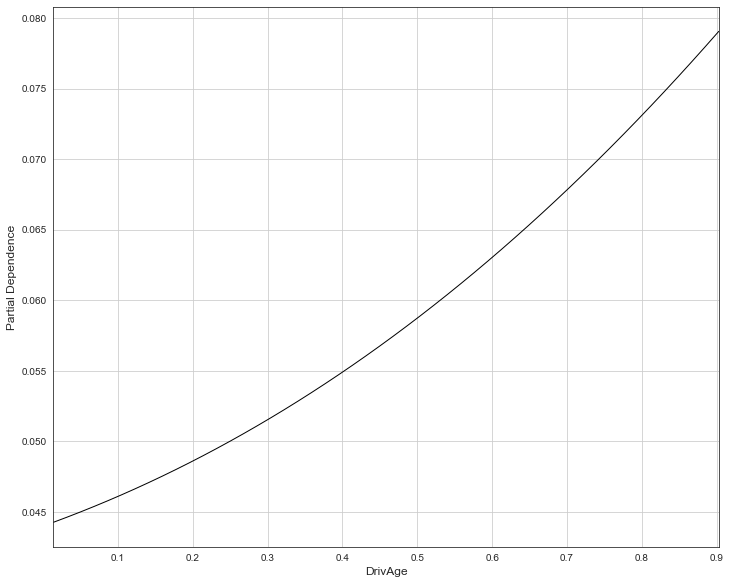

Agent 5


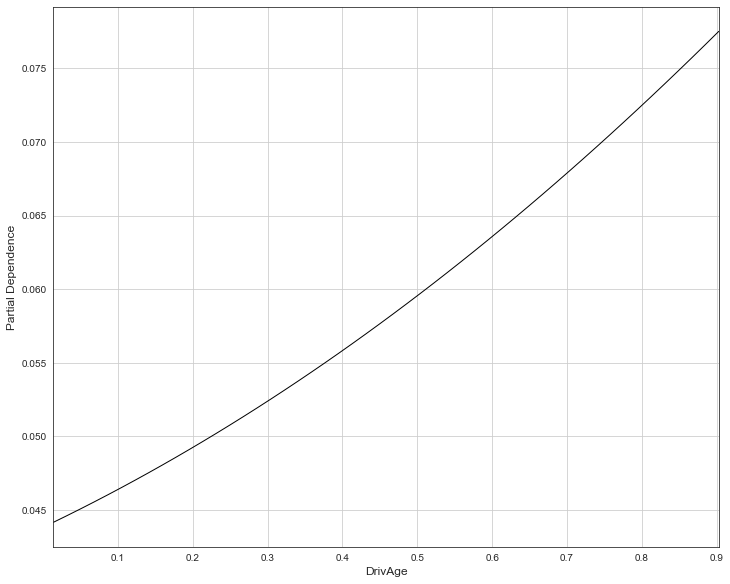

Agent 6


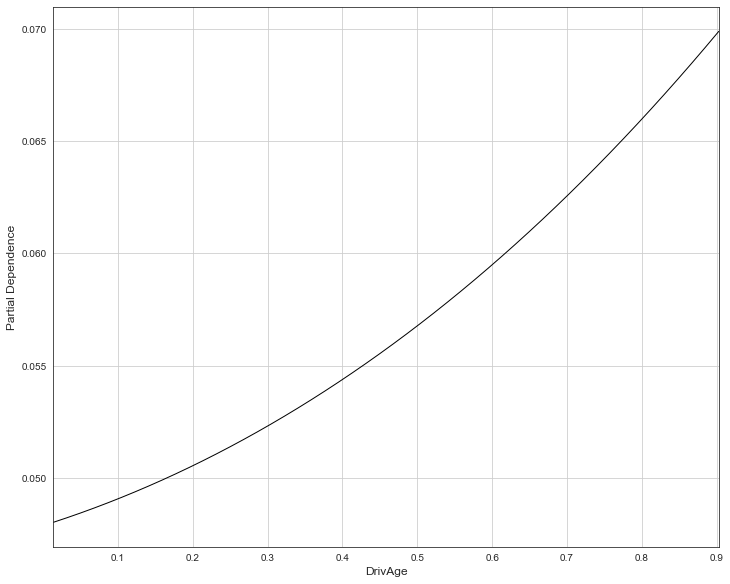

Agent 7


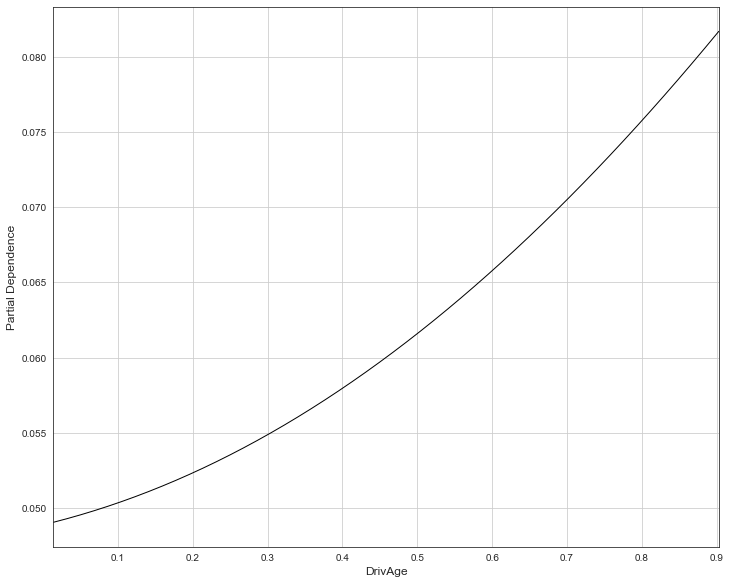

Agent 8


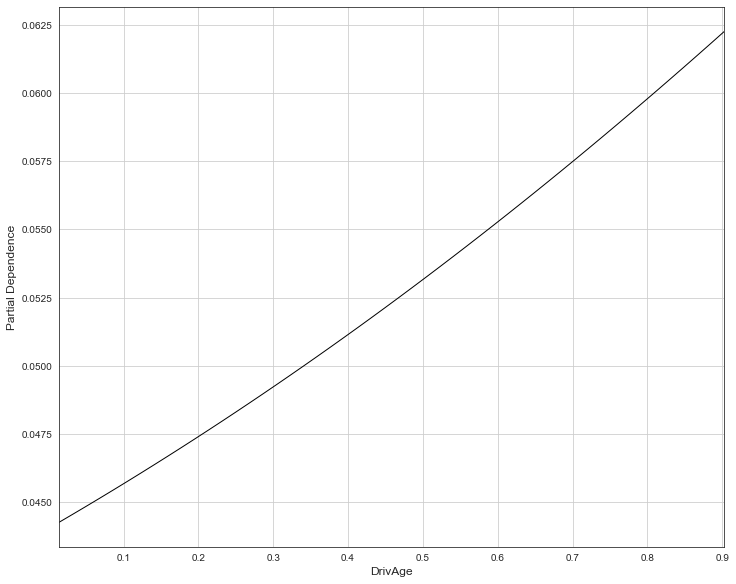

Agent 9


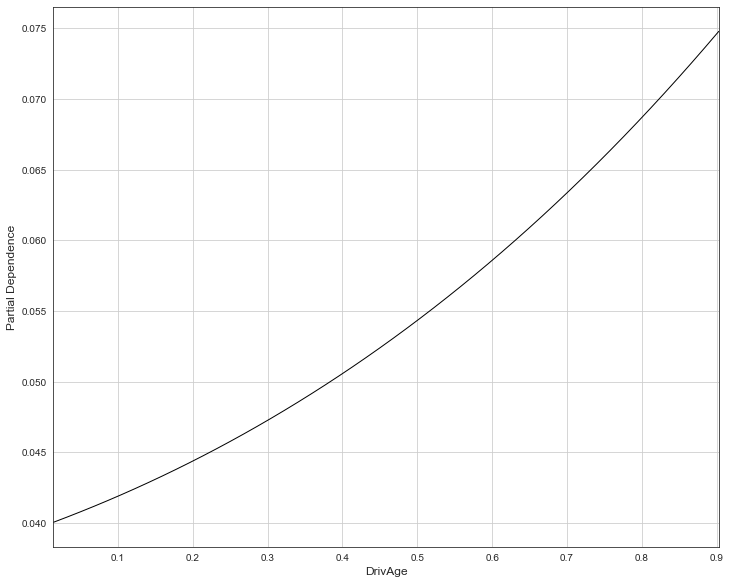

Feature 5
Agent 0


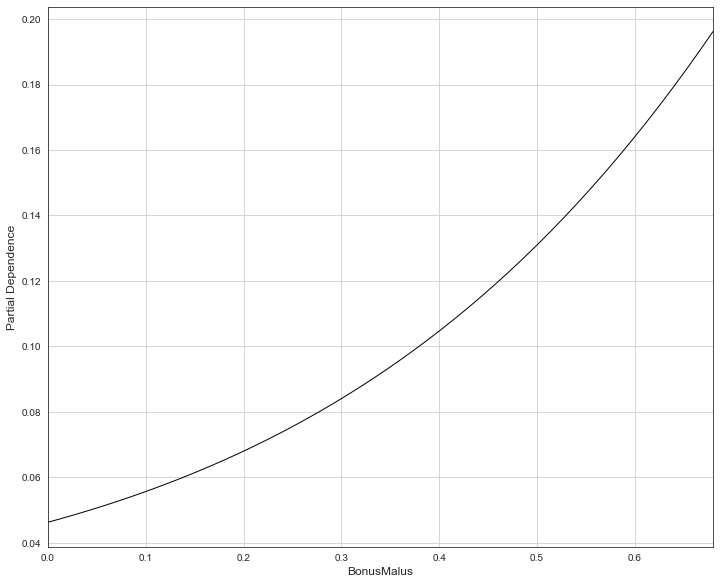

Agent 1


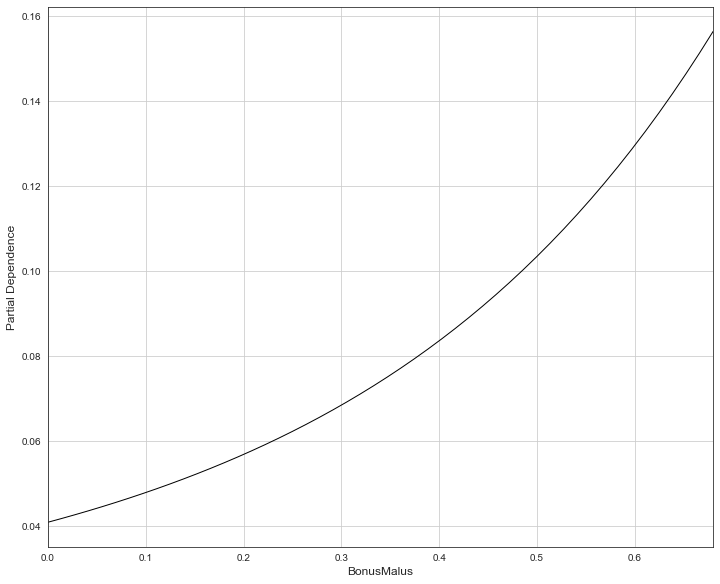

Agent 2


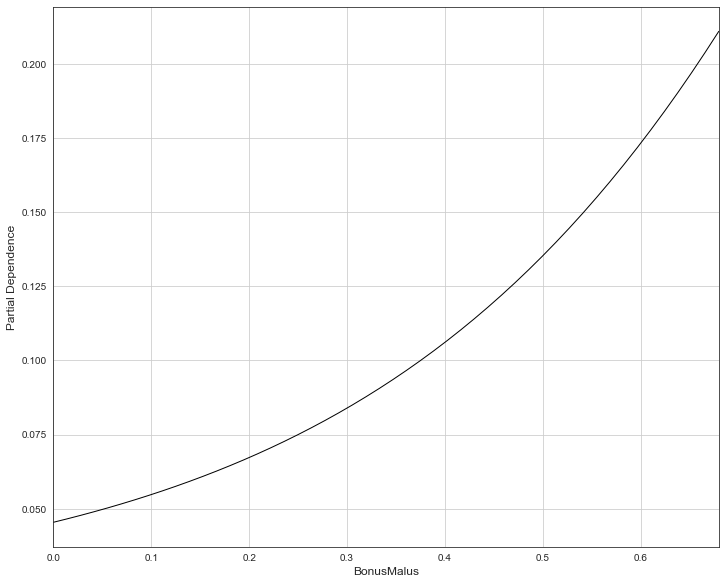

Agent 3


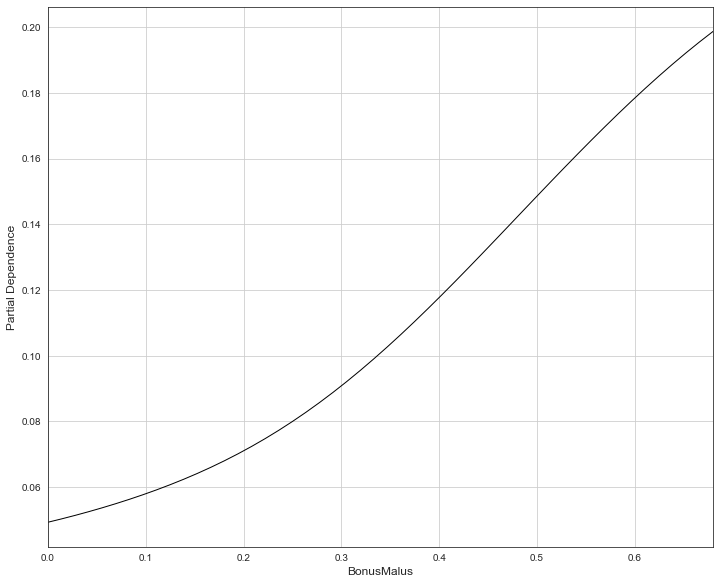

Agent 4


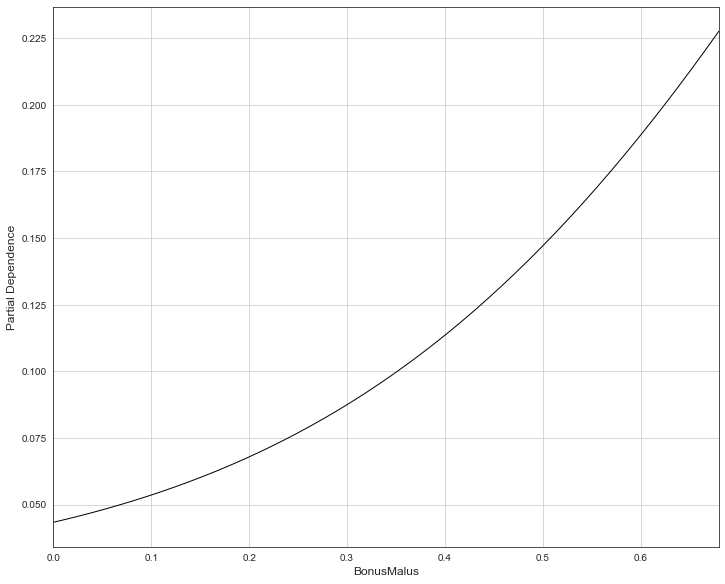

Agent 5


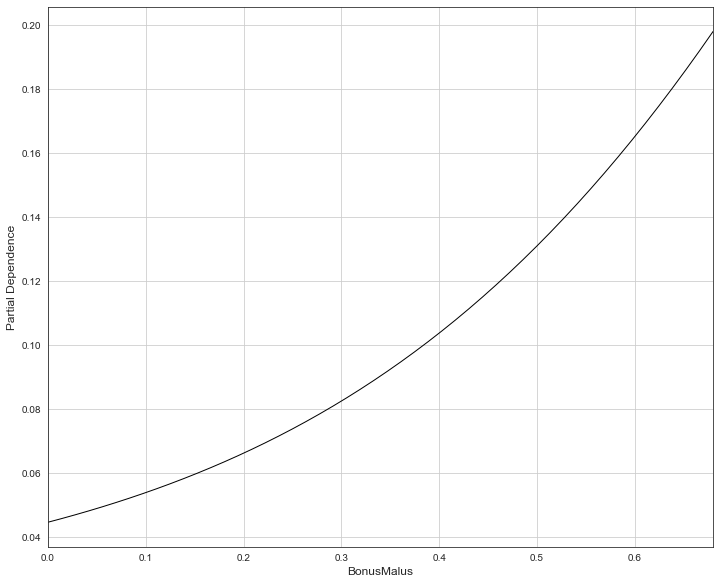

Agent 6


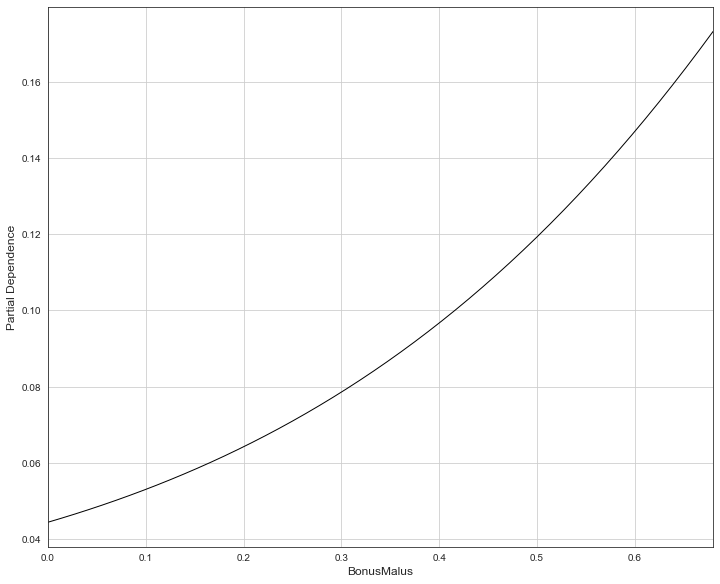

Agent 7


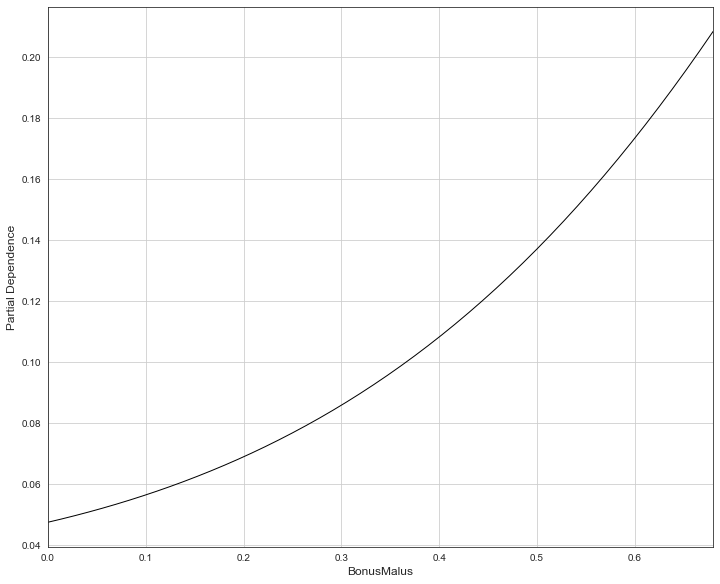

Agent 8


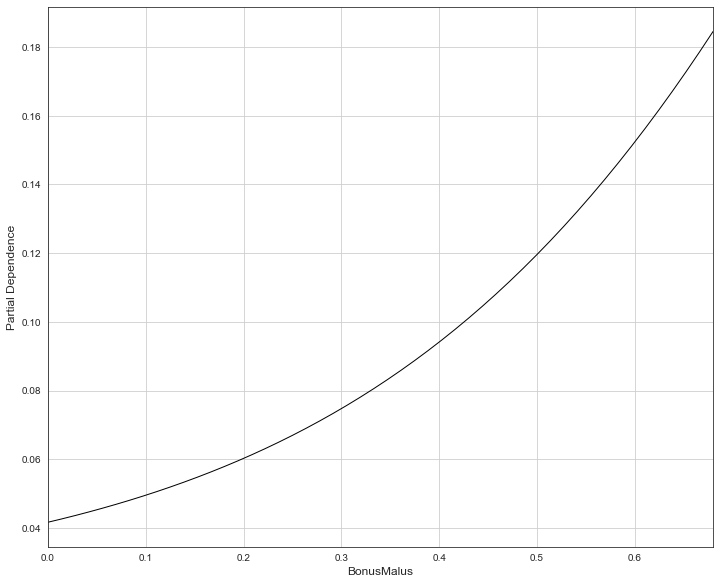

Agent 9


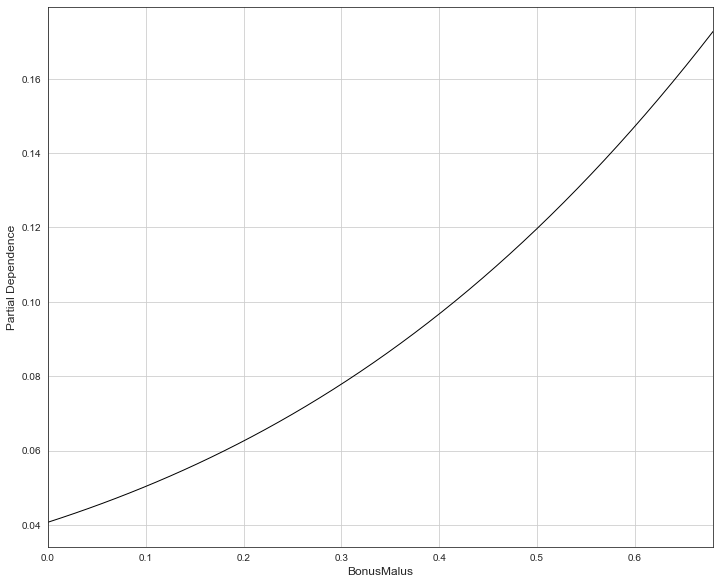

Feature 6
Agent 0


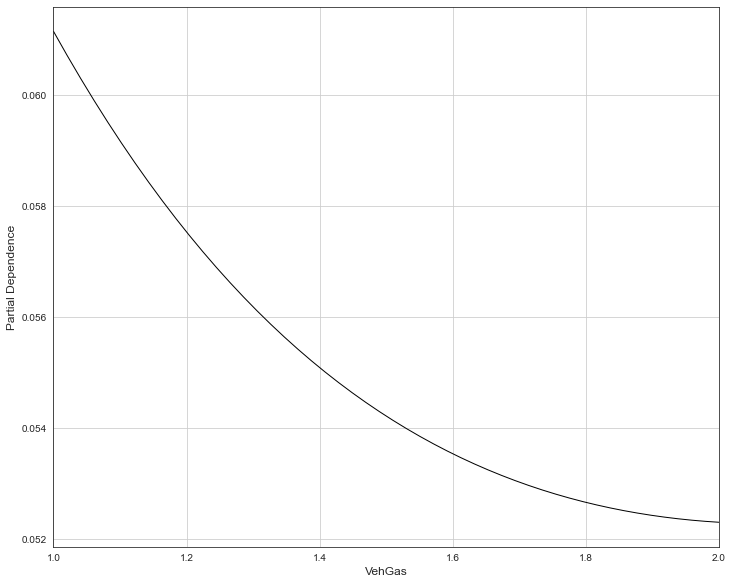

Agent 1


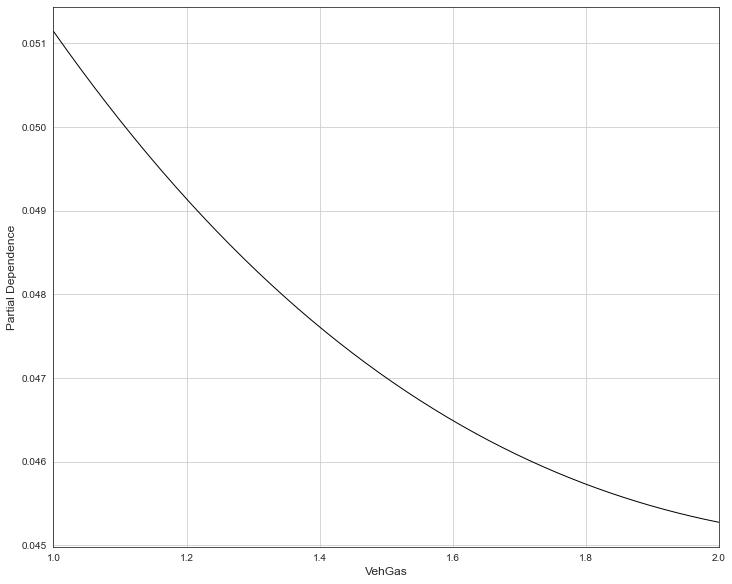

Agent 2


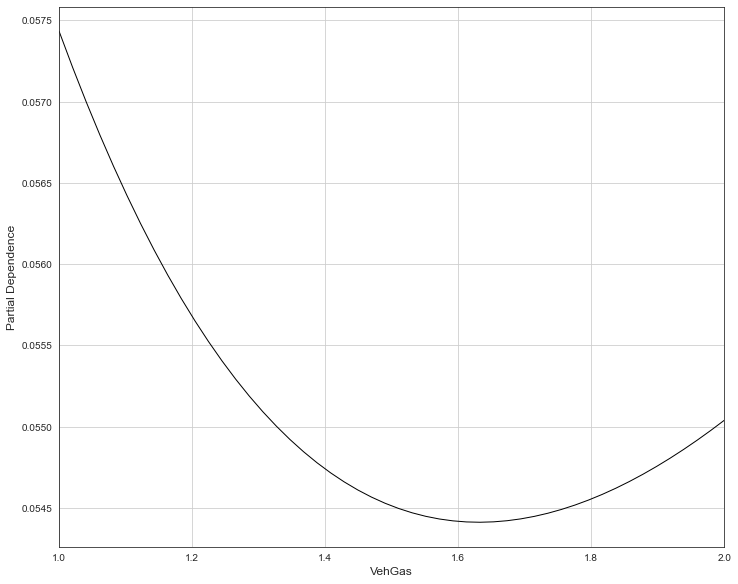

Agent 3


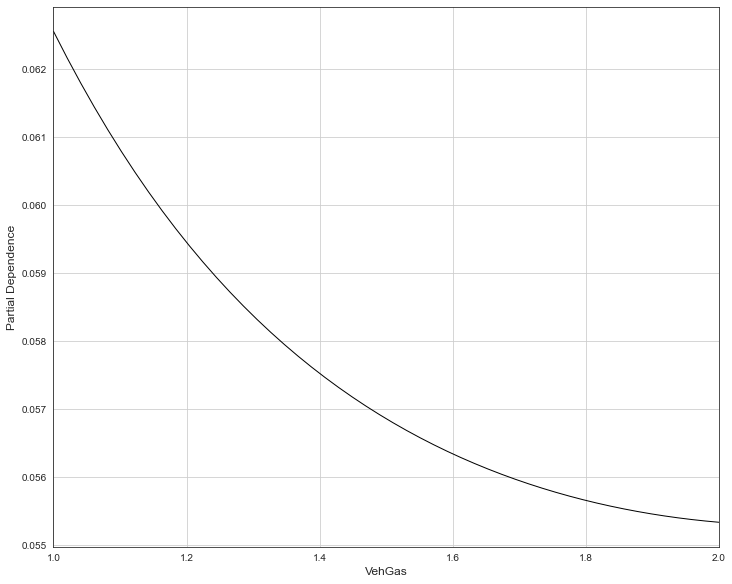

Agent 4


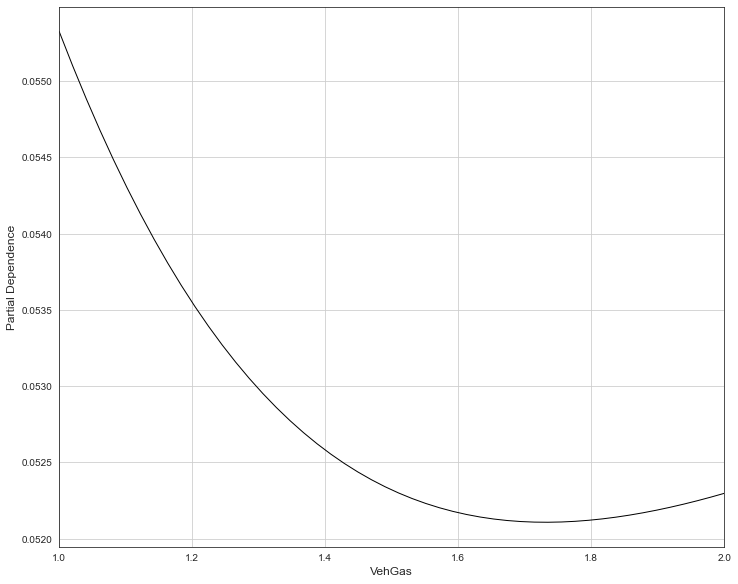

Agent 5


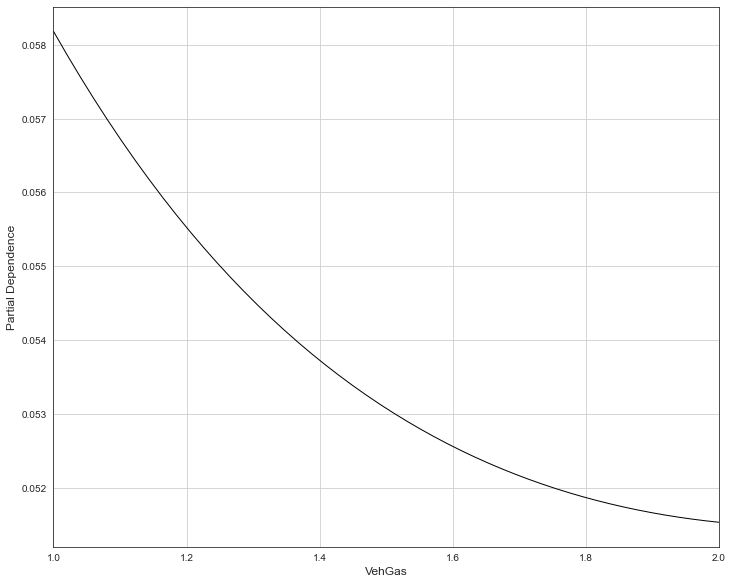

Agent 6


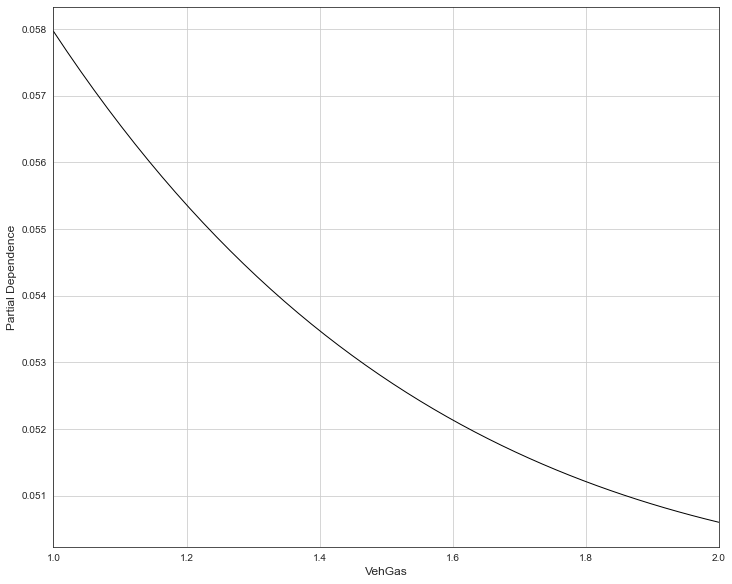

Agent 7


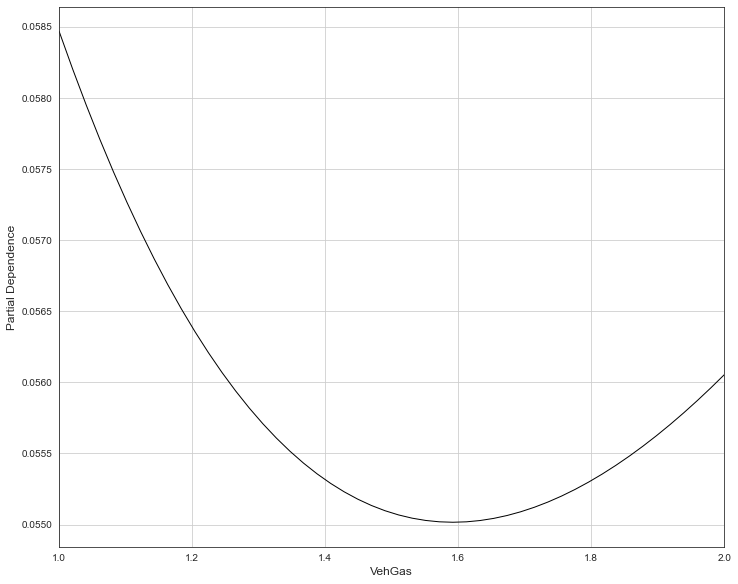

Agent 8


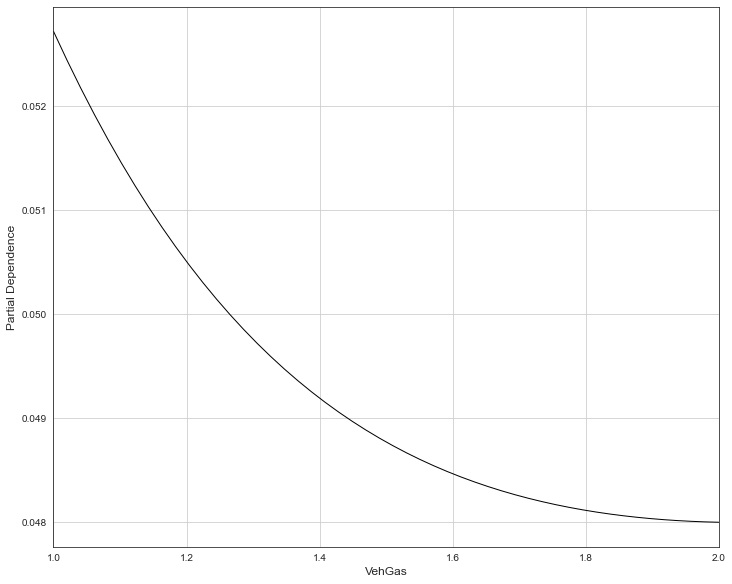

Agent 9


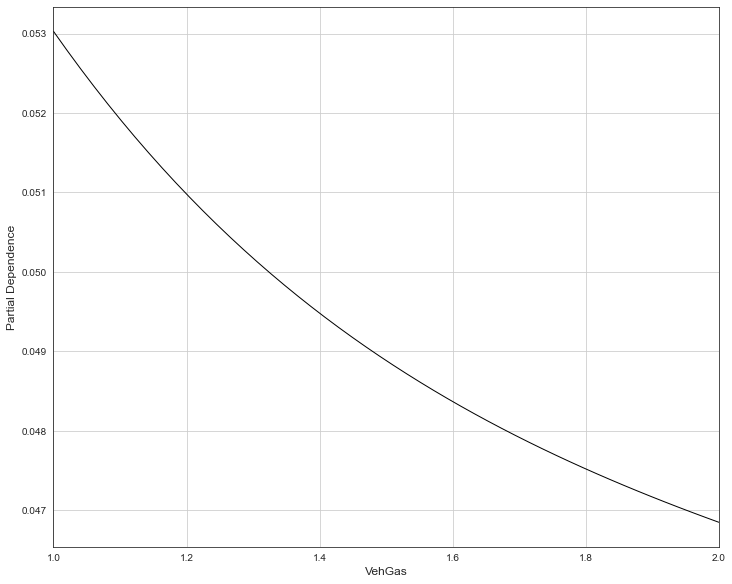

Feature 7
Agent 0


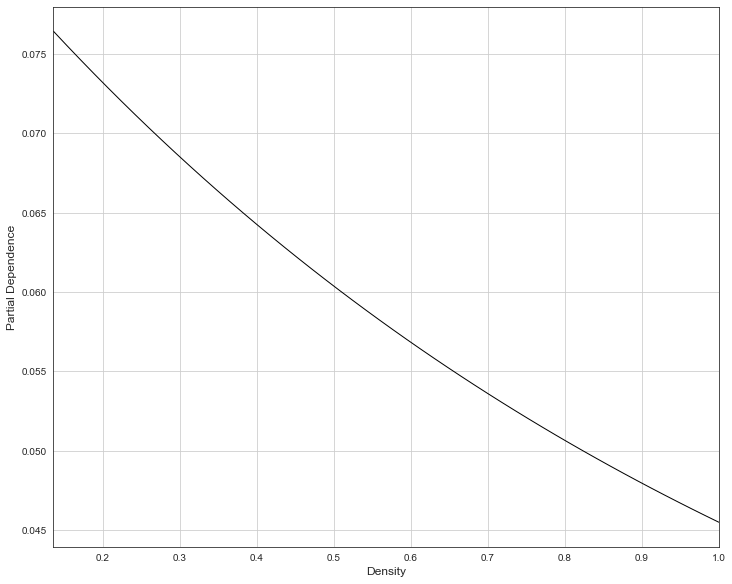

Agent 1


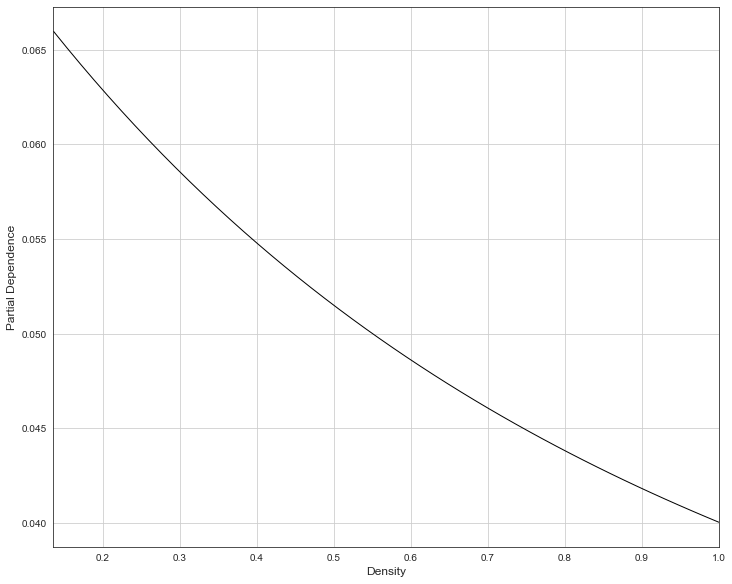

Agent 2


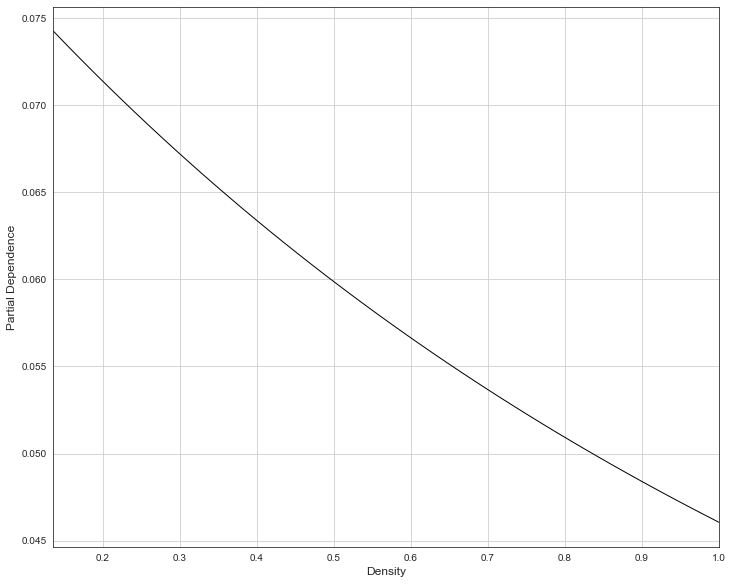

Agent 3


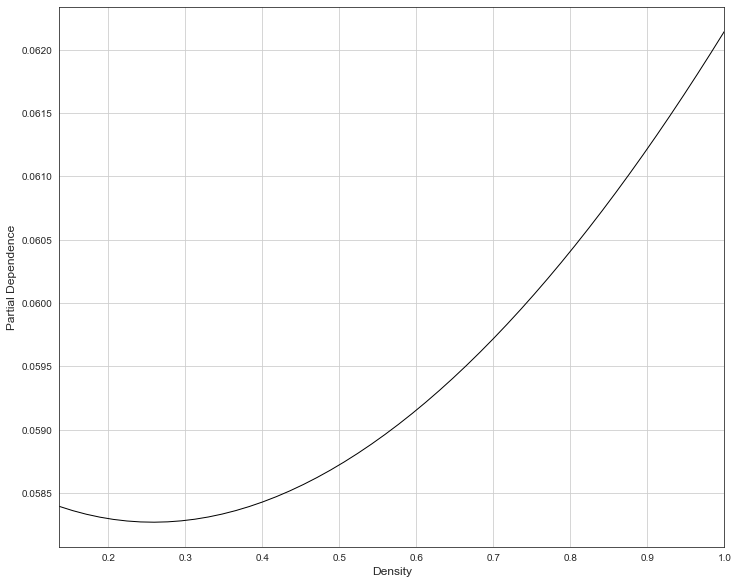

Agent 4


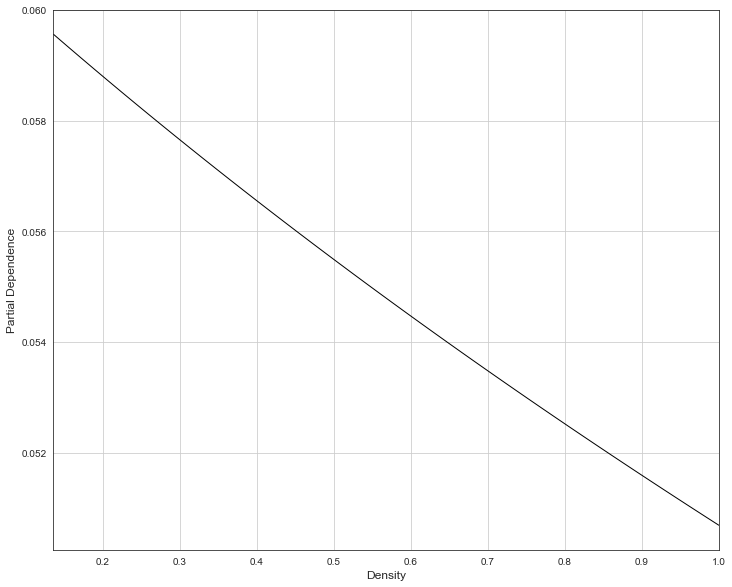

Agent 5


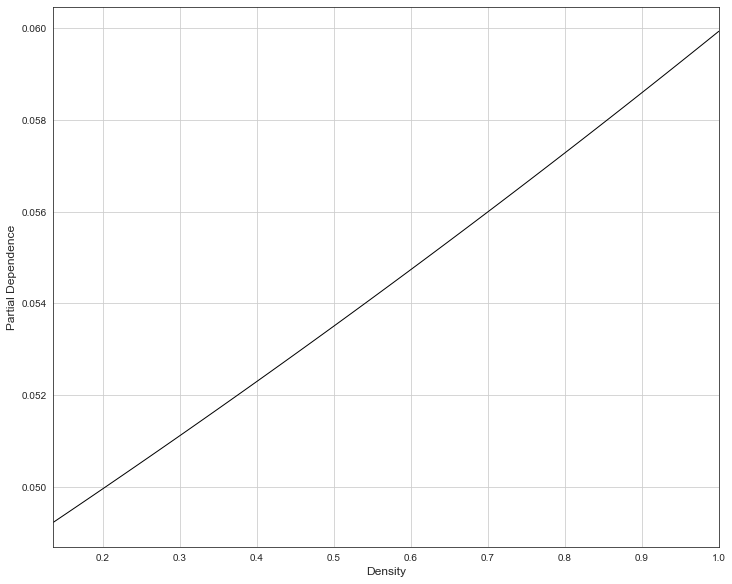

Agent 6


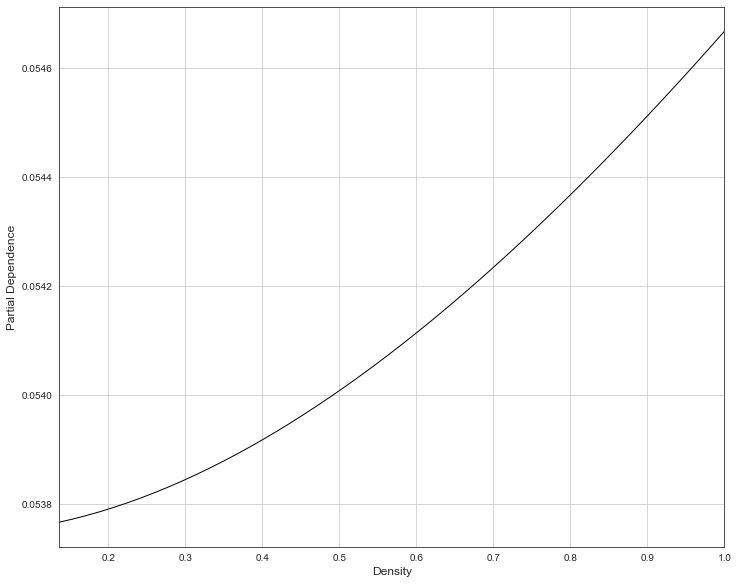

Agent 7


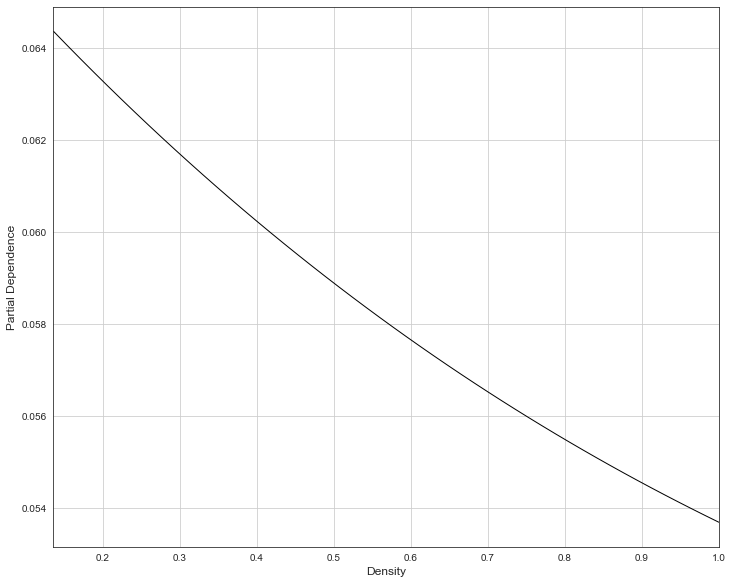

Agent 8


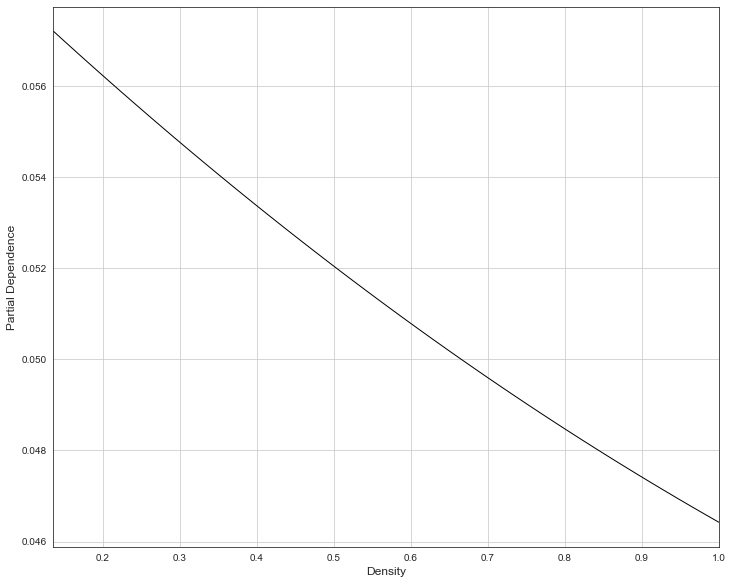

Agent 9


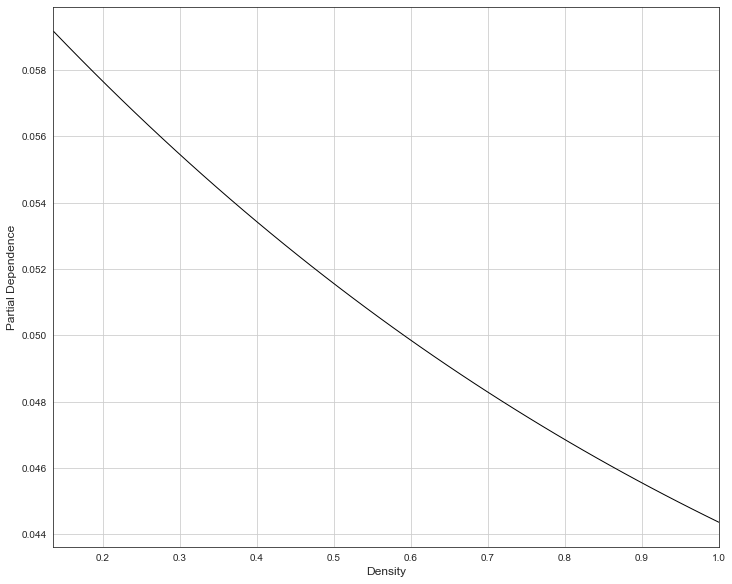

In [941]:
for i in range(0,8):
    print('Feature '+str(i))
    for j in range(0,10):
        print('Agent '+str(j))
        loaded_agent_j_model = load_model(agent=j)
        plot_partial_dependency(loaded_agent_j_model, X_test, y_test, i)

In [942]:
X_temp = X_test.copy()

In [689]:
X_temp[:, 4]

array([0.375     , 0.11111111, 0.04166667, ..., 0.52777778, 0.44444444,
       0.69444444])

In [690]:
x_scan = np.linspace(np.percentile(X_temp[:, 4], 0.1), np.percentile(X_temp[:, 4], 99.5), 50)
x_scan

array([0.01388889, 0.03202948, 0.05017007, 0.06831066, 0.08645125,
       0.10459184, 0.12273243, 0.14087302, 0.15901361, 0.1771542 ,
       0.19529478, 0.21343537, 0.23157596, 0.24971655, 0.26785714,
       0.28599773, 0.30413832, 0.32227891, 0.3404195 , 0.35856009,
       0.37670068, 0.39484127, 0.41298186, 0.43112245, 0.44926304,
       0.46740363, 0.48554422, 0.50368481, 0.5218254 , 0.53996599,
       0.55810658, 0.57624717, 0.59438776, 0.61252834, 0.63066893,
       0.64880952, 0.66695011, 0.6850907 , 0.70323129, 0.72137188,
       0.73951247, 0.75765306, 0.77579365, 0.79393424, 0.81207483,
       0.83021542, 0.84835601, 0.8664966 , 0.88463719, 0.90277778])

In [691]:
df_xscan = pd.DataFrame()
df_xscan['Area'] = pd.Series(x_scan)
df_xscan['VehPower'] = pd.Series(x_scan)
df_xscan['VehAge'] = pd.Series(x_scan)
df_xscan['DrivAge'] = pd.Series(x_scan)
df_xscan['BonusMalus'] = pd.Series(x_scan)
df_xscan['Density'] = pd.Series(x_scan)
df_xscan

Area  VehPower    VehAge   DrivAge  BonusMalus   Density
0   0.013889  0.013889  0.013889  0.013889    0.013889  0.013889
1   0.032029  0.032029  0.032029  0.032029    0.032029  0.032029
2   0.050170  0.050170  0.050170  0.050170    0.050170  0.050170
3   0.068311  0.068311  0.068311  0.068311    0.068311  0.068311
4   0.086451  0.086451  0.086451  0.086451    0.086451  0.086451
5   0.104592  0.104592  0.104592  0.104592    0.104592  0.104592
6   0.122732  0.122732  0.122732  0.122732    0.122732  0.122732
7   0.140873  0.140873  0.140873  0.140873    0.140873  0.140873
8   0.159014  0.159014  0.159014  0.159014    0.159014  0.159014
9   0.177154  0.177154  0.177154  0.177154    0.177154  0.177154
10  0.195295  0.195295  0.195295  0.195295    0.195295  0.195295
11  0.213435  0.213435  0.213435  0.213435    0.213435  0.213435
12  0.231576  0.231576  0.231576  0.231576    0.231576  0.231576
13  0.249717  0.249717  0.249717  0.249717    0.249717  0.249717
14  0.267857  0.267857  0.267857  0.267857    0.267857  0.267857
15  0.285998  0.285998  0.285998  0.285998    0.285998  0.285998
16  0.304138  0.304138  0.304138  0.304138    0.304138  0.304138
17  0.322279  0.322279  0.322279  0.322279    0.322279  0.322279
18  0.340420  0.340420  0.340420  0.340420    0.340420  0.340420
19  0.358560  0.358560  0.358560  0.358560    0.358560  0.358560
20  0.376701  0.376701  0.376701  0.376701    0.376701  0.376701
21  0.394841  0.394841  0.394841  0.394841    0.394841  0.394841
22  0.412982  0.412982  0.412982  0.412982    0.412982  0.412982
23  0.431122  0.431122  0.431122  0.431122    0.431122  0.431122
24  0.449263  0.449263  0.449263  0.449263    0.449263  0.449263
25  0.467404  0.467404  0.467404  0.467404    0.467404  0.467404
26  0.485544  0.485544  0.485544  0.485544    0.485544  0.485544
27  0.503685  0.503685  0.503685  0.503685    0.503685  0.503685
28  0.521825  0.521825  0.521825  0.521825    0.521825  0.521825
29  0.539966  0.539966  0.539966  0.539966    0.539966  0.539966
30  0.558107  0.558107  0.558107  0.558107    0.558107  0.558107
31  0.576247  0.576247  0.576247  0.576247    0.576247  0.576247
32  0.594388  0.594388  0.594388  0.594388    0.594388  0.594388
33  0.612528  0.612528  0.612528  0.612528    0.612528  0.612528
34  0.630669  0.630669  0.630669  0.630669    0.630669  0.630669
35  0.648810  0.648810  0.648810  0.648810    0.648810  0.648810
36  0.666950  0.666950  0.666950  0.666950    0.666950  0.666950
37  0.685091  0.685091  0.685091  0.685091    0.685091  0.685091
38  0.703231  0.703231  0.703231  0.703231    0.703231  0.703231
39  0.721372  0.721372  0.721372  0.721372    0.721372  0.721372
40  0.739512  0.739512  0.739512  0.739512    0.739512  0.739512
41  0.757653  0.757653  0.757653  0.757653    0.757653  0.757653
42  0.775794  0.775794  0.775794  0.775794    0.775794  0.775794
43  0.793934  0.793934  0.793934  0.793934    0.793934  0.793934
44  0.812075  0.812075  0.812075  0.812075    0.812075  0.812075
45  0.830215  0.830215  0.830215  0.830215    0.830215  0.830215
46  0.848356  0.848356  0.848356  0.848356    0.848356  0.848356
47  0.866497  0.866497  0.866497  0.866497    0.866497  0.866497
48  0.884637  0.884637  0.884637  0.884637    0.884637  0.884637
49  0.902778  0.902778  0.902778  0.902778    0.902778  0.902778

In [692]:
df_xscan[['Area_transform', 'VehPower_transform', 'VehAge_transform','DrivAge_transform','BonusMalus_transform','Density_transform']] = scaler.inverse_transform(df_xscan[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']])
df_xscan

Area  VehPower    VehAge   DrivAge  BonusMalus   Density  \
0   0.013889  0.013889  0.013889  0.013889    0.013889  0.013889   
1   0.032029  0.032029  0.032029  0.032029    0.032029  0.032029   
2   0.050170  0.050170  0.050170  0.050170    0.050170  0.050170   
3   0.068311  0.068311  0.068311  0.068311    0.068311  0.068311   
4   0.086451  0.086451  0.086451  0.086451    0.086451  0.086451   
5   0.104592  0.104592  0.104592  0.104592    0.104592  0.104592   
6   0.122732  0.122732  0.122732  0.122732    0.122732  0.122732   
7   0.140873  0.140873  0.140873  0.140873    0.140873  0.140873   
8   0.159014  0.159014  0.159014  0.159014    0.159014  0.159014   
9   0.177154  0.177154  0.177154  0.177154    0.177154  0.177154   
10  0.195295  0.195295  0.195295  0.195295    0.195295  0.195295   
11  0.213435  0.213435  0.213435  0.213435    0.213435  0.213435   
12  0.231576  0.231576  0.231576  0.231576    0.231576  0.231576   
13  0.249717  0.249717  0.249717  0.249717    0.249717  0.249717   
14  0.267857  0.267857  0.267857  0.267857    0.267857  0.267857   
15  0.285998  0.285998  0.285998  0.285998    0.285998  0.285998   
16  0.304138  0.304138  0.304138  0.304138    0.304138  0.304138   
17  0.322279  0.322279  0.322279  0.322279    0.322279  0.322279   
18  0.340420  0.340420  0.340420  0.340420    0.340420  0.340420   
19  0.358560  0.358560  0.358560  0.358560    0.358560  0.358560   
20  0.376701  0.376701  0.376701  0.376701    0.376701  0.376701   
21  0.394841  0.394841  0.394841  0.394841    0.394841  0.394841   
22  0.412982  0.412982  0.412982  0.412982    0.412982  0.412982   
23  0.431122  0.431122  0.431122  0.431122    0.431122  0.431122   
24  0.449263  0.449263  0.449263  0.449263    0.449263  0.449263   
25  0.467404  0.467404  0.467404  0.467404    0.467404  0.467404   
26  0.485544  0.485544  0.485544  0.485544    0.485544  0.485544   
27  0.503685  0.503685  0.503685  0.503685    0.503685  0.503685   
28  0.521825  0.521825  0.521825  0.521825    0.521825  0.521825   
29  0.539966  0.539966  0.539966  0.539966    0.539966  0.539966   
30  0.558107  0.558107  0.558107  0.558107    0.558107  0.558107   
31  0.576247  0.576247  0.576247  0.576247    0.576247  0.576247   
32  0.594388  0.594388  0.594388  0.594388    0.594388  0.594388   
33  0.612528  0.612528  0.612528  0.612528    0.612528  0.612528   
34  0.630669  0.630669  0.630669  0.630669    0.630669  0.630669   
35  0.648810  0.648810  0.648810  0.648810    0.648810  0.648810   
36  0.666950  0.666950  0.666950  0.666950    0.666950  0.666950   
37  0.685091  0.685091  0.685091  0.685091    0.685091  0.685091   
38  0.703231  0.703231  0.703231  0.703231    0.703231  0.703231   
39  0.721372  0.721372  0.721372  0.721372    0.721372  0.721372   
40  0.739512  0.739512  0.739512  0.739512    0.739512  0.739512   
41  0.757653  0.757653  0.757653  0.757653    0.757653  0.757653   
42  0.775794  0.775794  0.775794  0.775794    0.775794  0.775794   
43  0.793934  0.793934  0.793934  0.793934    0.793934  0.793934   
44  0.812075  0.812075  0.812075  0.812075    0.812075  0.812075   
45  0.830215  0.830215  0.830215  0.830215    0.830215  0.830215   
46  0.848356  0.848356  0.848356  0.848356    0.848356  0.848356   
47  0.866497  0.866497  0.866497  0.866497    0.866497  0.866497   
48  0.884637  0.884637  0.884637  0.884637    0.884637  0.884637   
49  0.902778  0.902778  0.902778  0.902778    0.902778  0.902778   

    Area_transform  VehPower_transform  VehAge_transform  DrivAge_transform  \
0         1.069444            4.152778          0.277778          19.000000   
1         1.160147            4.352324          0.640590          20.306122   
2         1.250850            4.551871          1.003401          21.612245   
3         1.341553            4.751417          1.366213          22.918367   
4         1.432256            4.950964          1.729025          24.224490   
5         1.522959            5.150510          2.091837         

In [693]:
y_partial = []

for point in x_scan:

    X_temp[:, 4] = point

    #dpartial = xgb.DMatrix(X_temp[:, feature_ids])

    # Global Model Predictions
    #y_pred = global_model.predict(X_test.astype(np.float64))
    
    #y_partial.append(np.average(bst.predict(X_temp)))
    y_partial.append(np.average(loaded_agent_global_model.predict(X_temp.astype(np.float64))))

y_partial = np.array(y_partial)

    # Plot partial dependence

Text(0, 0.5, 'Partial Dependence')

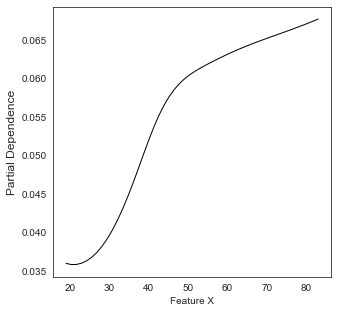

In [696]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

ax.plot(df_xscan['DrivAge_transform'], y_partial, '-', color = 'black', linewidth = 1)
#ax.plot(X[:, f_id], y, 'o', color = 'blue', alpha = 0.02)

#ax.set_xlim(min(x_scan), max(x_scan))
ax.set_xlabel('Feature X', fontsize = 10)    
ax.set_ylabel('Partial Dependence', fontsize = 12)

In [40]:
'{:.2%}'.format(weighted_pde_df.sort_values(by=['test_weighted_pde'], ascending=False).reset_index(drop=True).iloc[1:2,1].tolist()[0])

'4.80%'

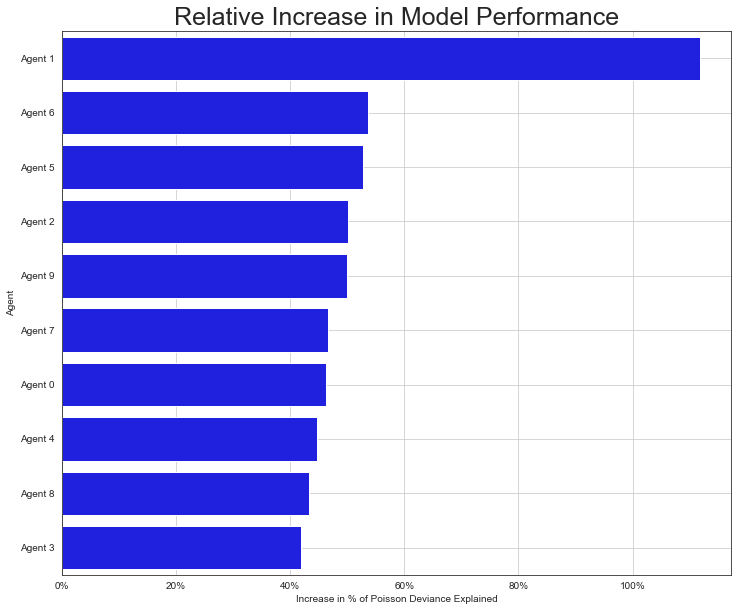

In [943]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(y='model', 
               x='fl_relative_increase',
               data=weighted_pde_df[~weighted_pde_df.agent.isin([-1, -2])].sort_values(by=['fl_relative_increase'], ascending = False),
               orient='h',
               color='blue',
               )
plt.title('Relative Increase in Model Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Increase in % of Poisson Deviance Explained', fontsize=10)
plt.ylabel('Agent', fontsize=10)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

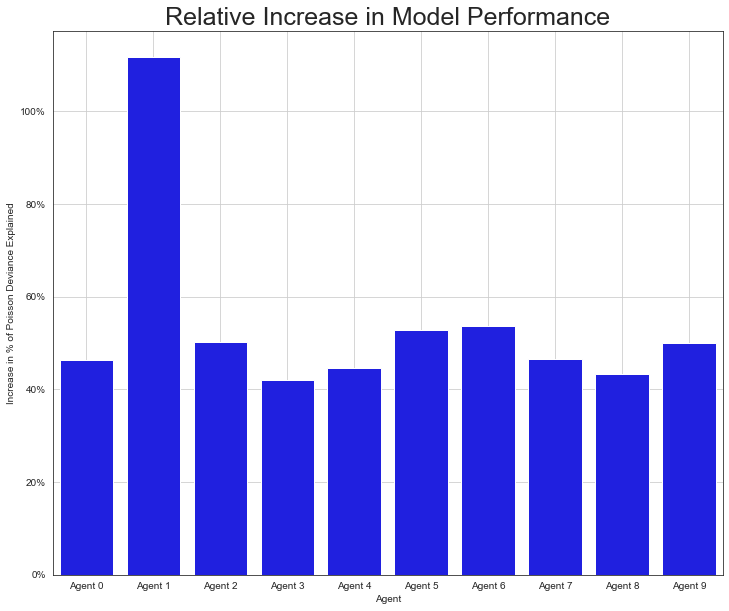

In [944]:
fig, ax = plt.subplots(figsize=(12,10))

sns.set_style('white')

ax=sns.barplot(x='model', 
               y='fl_relative_increase',
               data=weighted_pde_df[~weighted_pde_df.agent.isin([-1, -2])],
               #orient='h',
               color='blue',
               )
plt.title('Relative Increase in Model Performance', fontsize=25)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Increase in % of Poisson Deviance Explained', fontsize=10)
plt.xlabel('Agent', fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

In [43]:
import csv
import json

In [44]:
def read_csv(filename):
    loss_stats_dict = dict()
    with open(filename) as f:
        file_data=csv.reader(f)
        headers=next(file_data)
        round = 0
        for i in file_data:
            loss_stats_dict[round] = dict(zip(headers,i))
            round +=1
    return loss_stats_dict

In [45]:
loss_stats = dict()
for ag_id in range(-1, NUM_AGENTS):
    if ag_id == -1:
        MY_DATA_PATH = '../../../3agents/IFoA-FL-WP/ag_global'
    else:    
        MY_DATA_PATH = '../../../3agents/IFoA-FL-WP/ag_' + str(ag_id)
    
    loss_stats[ag_id] = read_csv(MY_DATA_PATH + '/los_stats.csv')

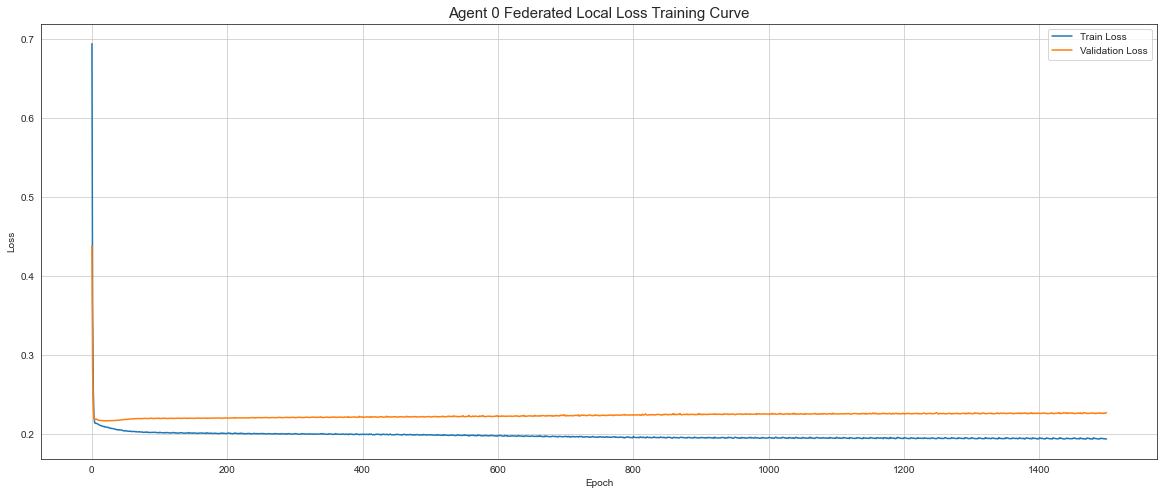

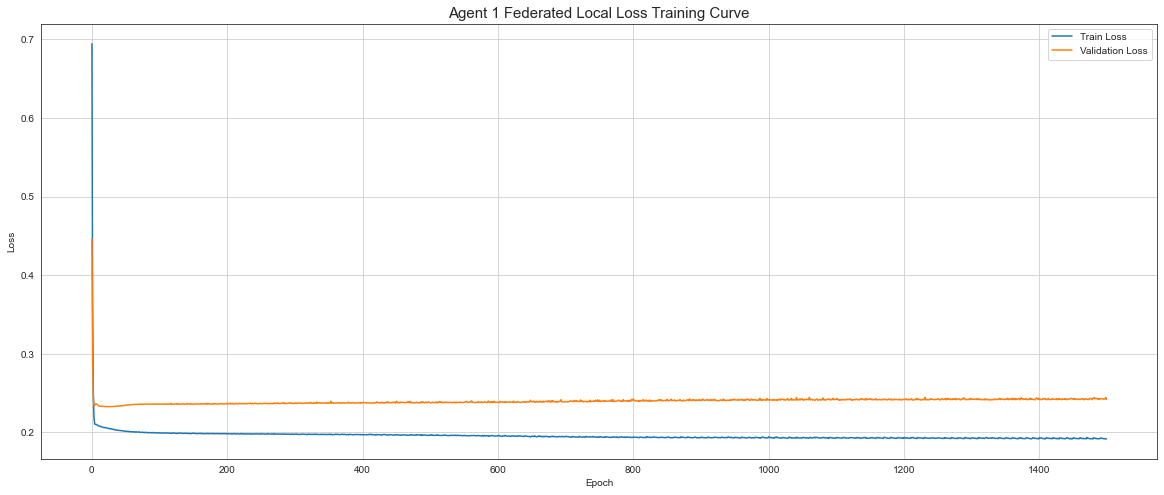

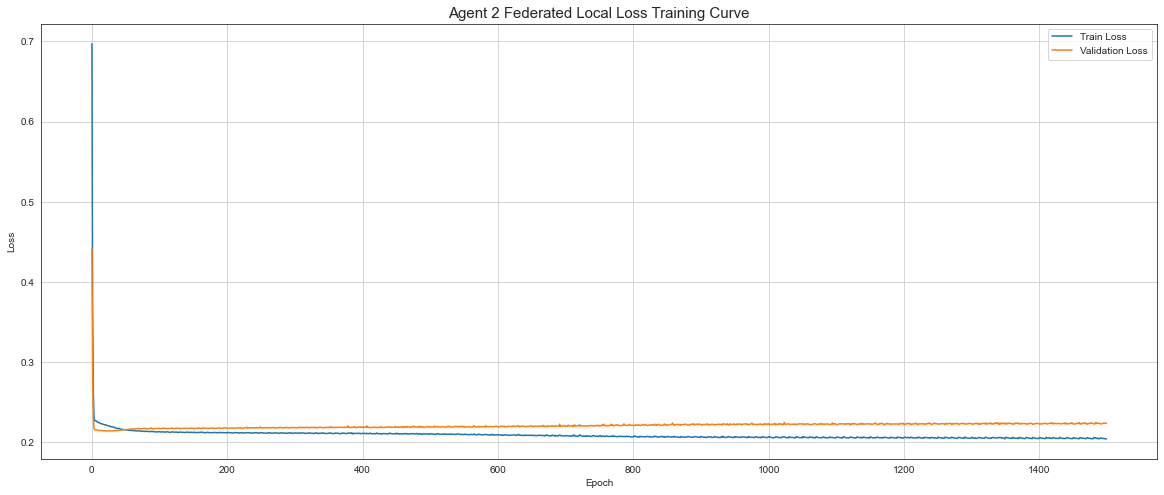

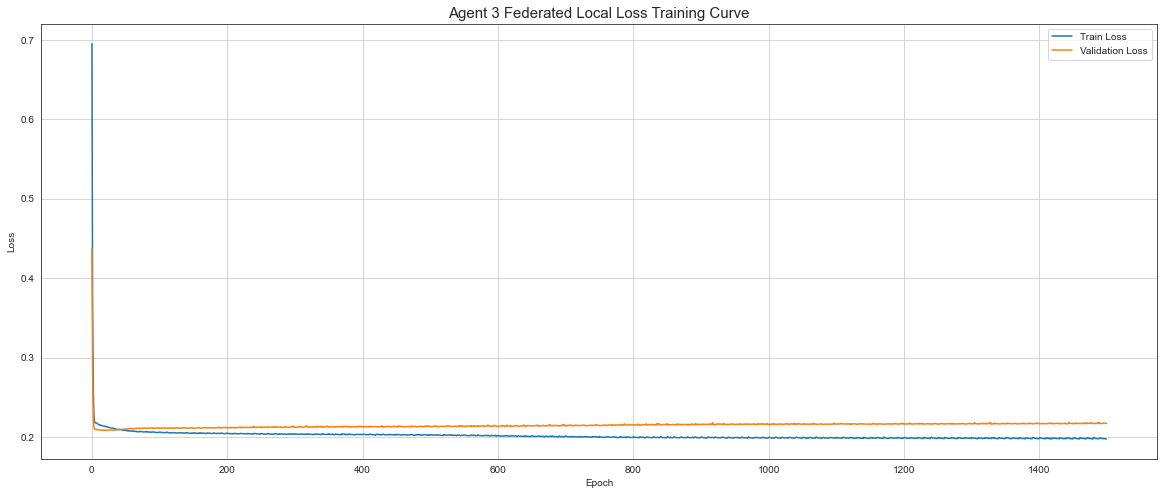

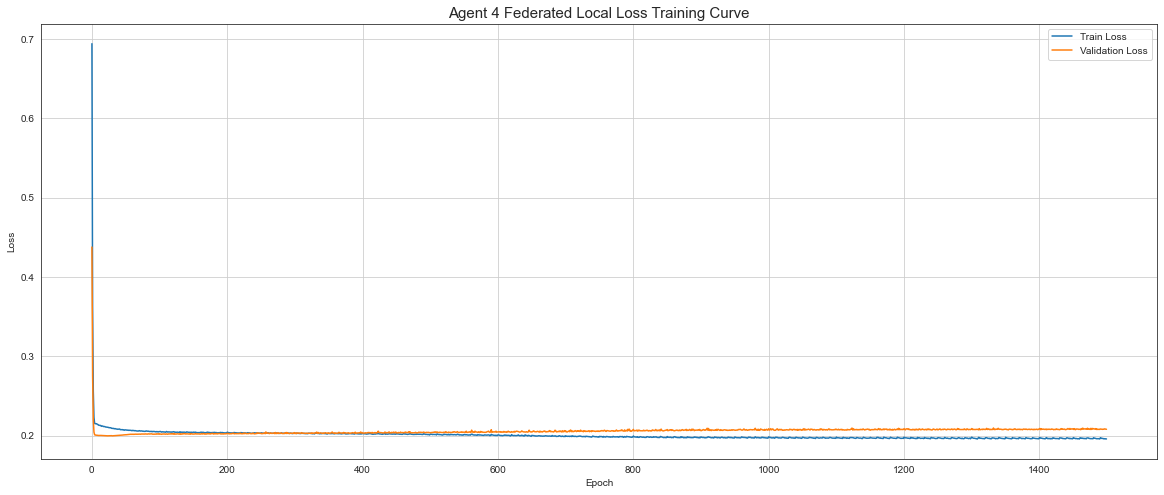

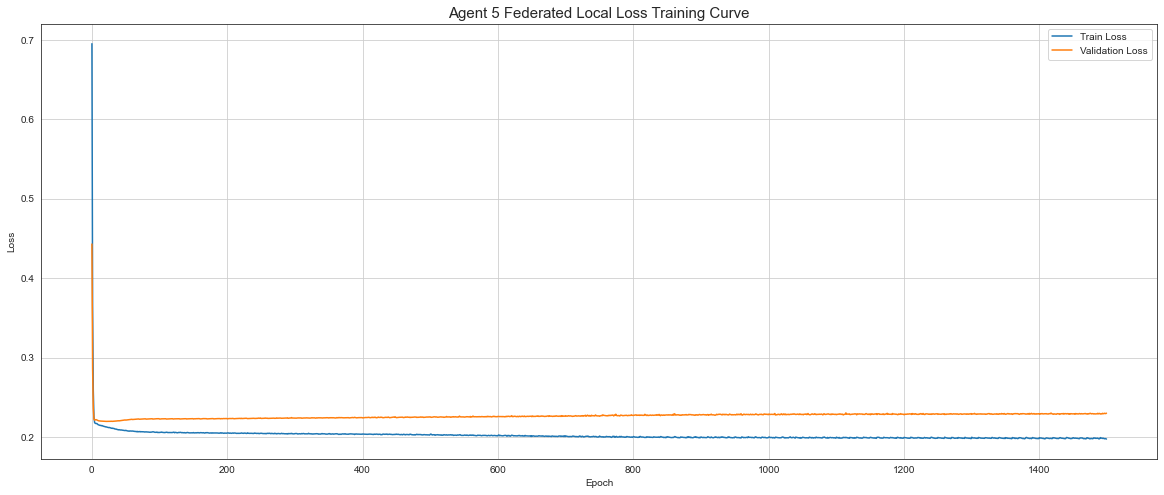

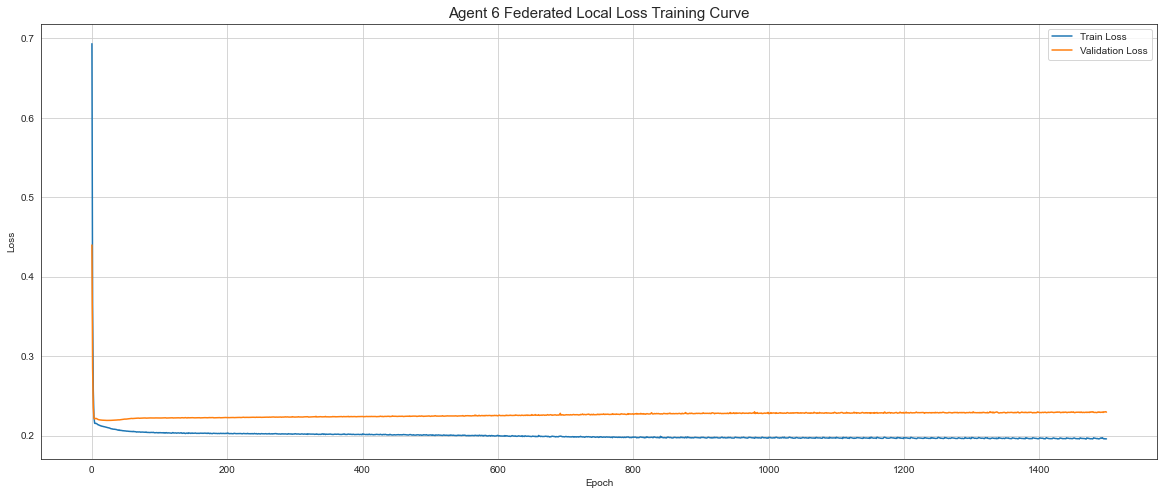

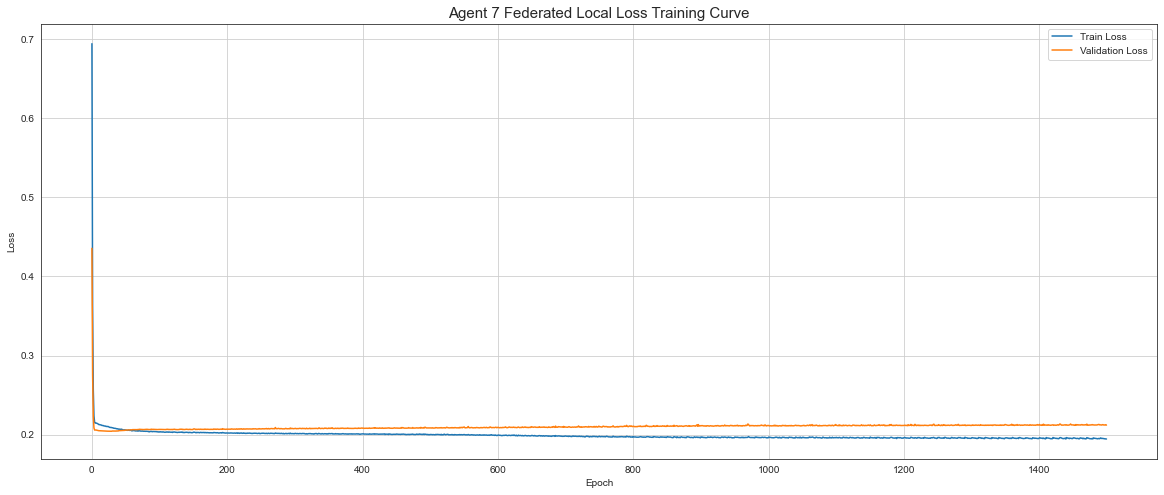

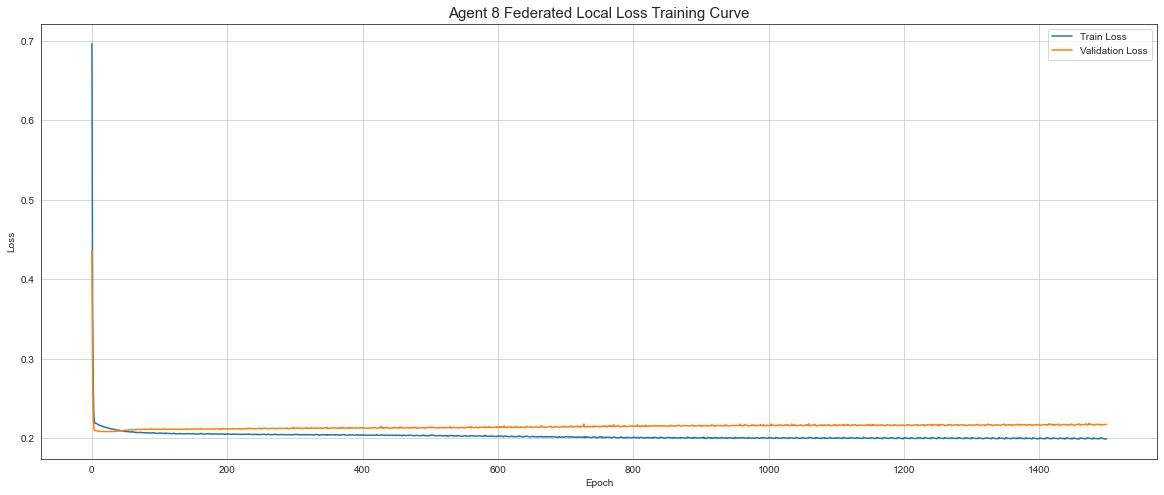

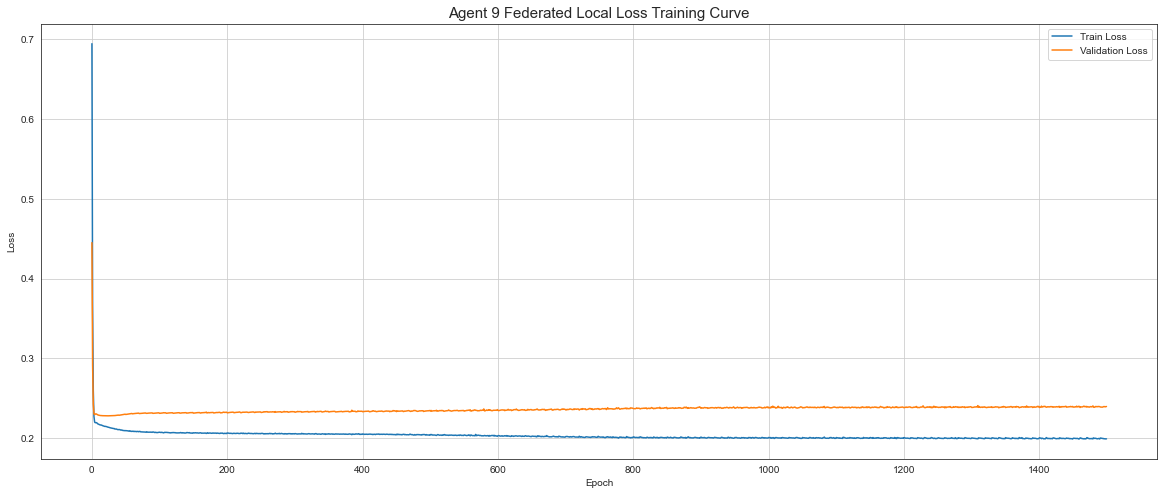

In [46]:
for ag in range(0,10):
    loss_train_list = []
    loss_val_list = []
    for rnd_no in range(0, NUM_ROUNDS*2 +1):
                    if rnd_no % 2 != 0: # FIXED : TO_FIX !!!!!!!!    MS: -1 added temporarly!!!! I need to find out why some clients join from 2nd round ( ask Malgorzata if that is not clear :) 
                        y_train_loss = json.loads(loss_stats[ag][rnd_no]["train"])
                        loss_train_list.extend(y_train_loss)
                        y_val_loss = json.loads(loss_stats[ag][rnd_no]["val"])
                        loss_val_list.extend(y_val_loss)
    plt.figure(figsize=(20,8))
    plt.plot(loss_train_list[:], label='Train Loss')
    plt.plot(loss_val_list[:], label='Validation Loss')
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title(f'Agent {ag} Federated Local Loss Training Curve', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()